In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.applications import vgg16, inception_v3
from keras.models import Sequential, Model
from keras.layers import * 
from keras.utils.np_utils import to_categorical
from keras import regularizers
import tensorflow as tf
from keras import initializers, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam, Adadelta, SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
np.random.seed(1337)
from PIL import Image
from keras_tqdm import TQDMNotebookCallback
# %matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


['dataset-master', 'dataset2-master']


In [2]:
# reset
K.clear_session()

K.set_image_data_format('channels_last')

# This one is to test whether Keras can see the GPUs
K.get_session().list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 569489490),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:1, GPU, 569489490)]

In [3]:
dict_characters = {0:'NEUTROPHIL', 1:'EOSINOPHIL', 2:'MONOCYTE', 3:'LYMPHOCYTE'}
dict_characters2 = {0:'Polynuclear', 1:'Mononuclear'}

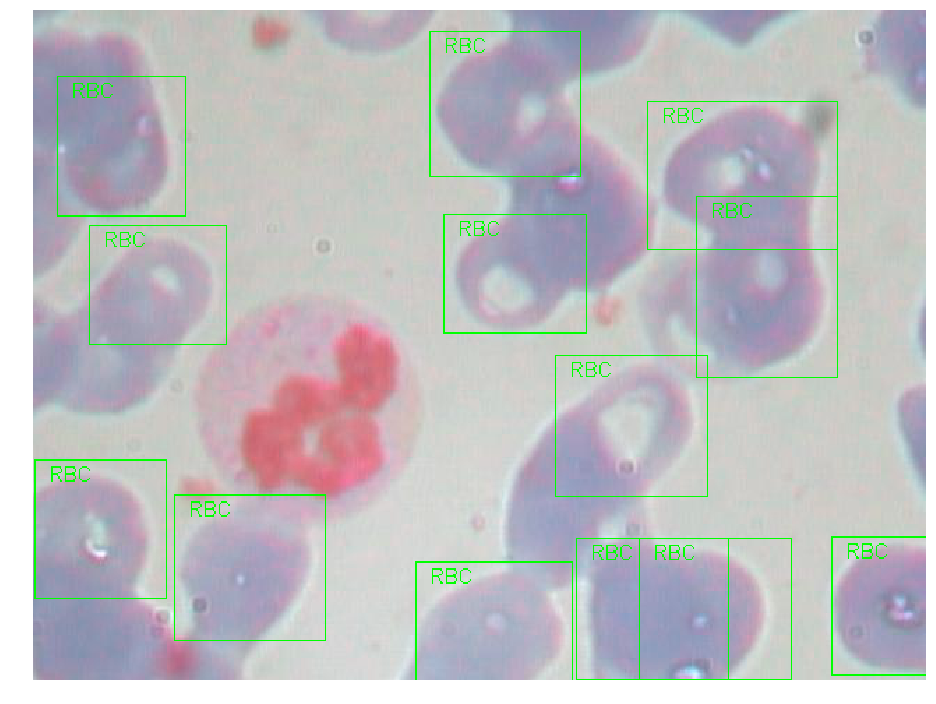

In [4]:
# Note that the function below is adapted from https://github.com/Shenggan/BCCD_Dataset
image = cv2.imread("../input/dataset-master/dataset-master/JPEGImages/BloodImage_00022.jpg")
tree = ET.parse("../input/dataset-master/dataset-master/Annotations/BloodImage_00022.xml")
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.axis('off') 
plt.show()

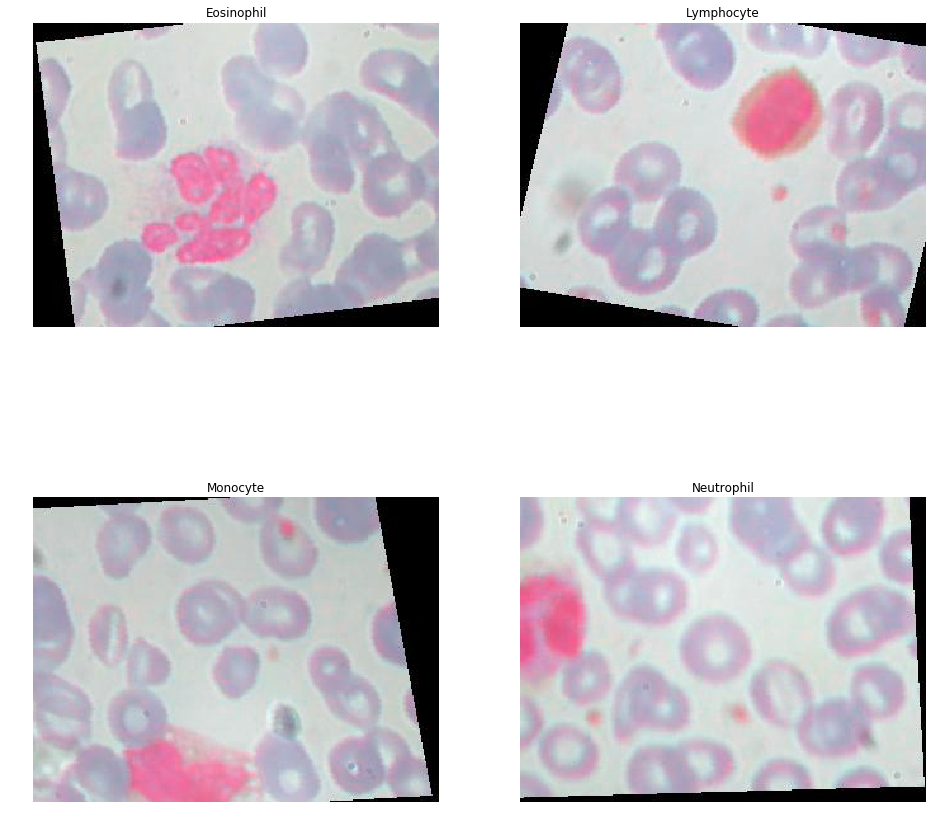

In [5]:
# Plot Image
def plotImage(image_location):
    image = cv2.imread(image_name)
    plt.imshow(image)
    return

image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.title('Eosinophil')
plt.axis('off') 
plotImage(image_name)
image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte')
plt.axis('off') 
plotImage(image_name)
image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte')
plt.axis('off') 
plotImage(image_name)
plt.subplot(224)
image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil')
plt.axis('off') 
plotImage(image_name)

In [6]:
def replaceBlackBackground(image, colour):
    image_data = np.array(image)
    red, green, blue = image_data.T
    # Replace black with color...
    black_areas = (red < 60) & (blue < 60) & (green < 60)
    image_data[black_areas.T] = colour
    return Image.fromarray(image_data)

new_background_colour = (210, 215, 213)

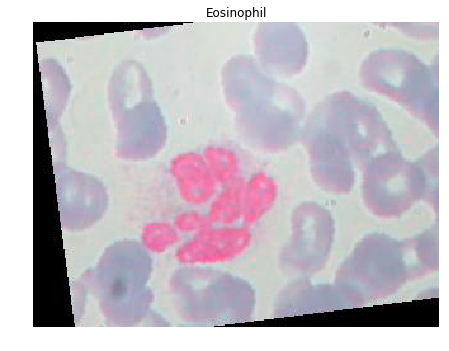

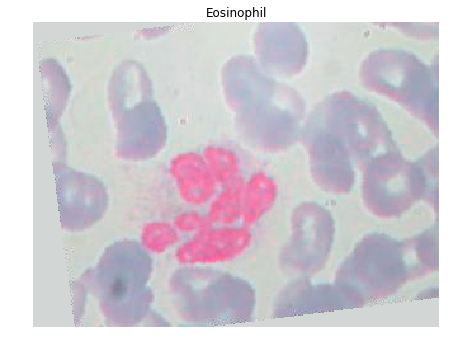

In [7]:
# Plot Image
def plotImage(image_location):
    image = cv2.imread(image_name)
    image2 = replaceBlackBackground(image, colour=new_background_colour)
    plt.figure(figsize=(16,16))
    plt.subplot(121)
    plt.title('Eosinophil')
    plt.axis('off') 
    plt.imshow(image)
    plt.figure(figsize=(16,16))
    plt.subplot(122)
    plt.title('Eosinophil')
    plt.axis('off') 
    plt.imshow(image2)
    return

image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plotImage(image_name)

[  3  88  33  21 207]


Text(0,0.5,'Counts')

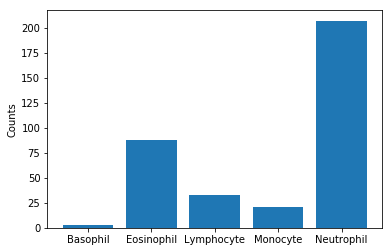

In [8]:
reader = csv.reader(open('../input/dataset2-master/dataset2-master/labels.csv'))
# skip the header
next(reader)
y3 = []
for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        y3.append(label)
y3 = np.asarray(y3)
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Counts')

In [9]:
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 0
                label2 = 0
            elif wbc_type in ['EOSINOPHIL']:
                label = 1
                label2 = 0
            elif wbc_type in ['MONOCYTE']:
                label = 2  
                label2 = 1
            elif wbc_type in ['LYMPHOCYTE']:
                label = 3
                label2 = 1
            # else:
            #     label = 4
            #     label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = replaceBlackBackground(img_file, new_background_colour)
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('../input/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('../input/dataset2-master/dataset2-master/images/TEST/')

  0%|                                                                                         | 0/2497 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:01<00:00, 546.94it/s]


In [10]:
def get_data2(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 0
                label2 = 0
            elif wbc_type in ['EOSINOPHIL']:
                label = 1
                label2 = 0
            elif wbc_type in ['MONOCYTE']:
                label = 2  
                label2 = 1
            elif wbc_type in ['LYMPHOCYTE']:
                label = 3
                label2 = 1
            # else:
            #     label = 4
            #     label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    #img_file = replaceBlackBackground(img_file, new_background_colour)
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train_2, y_train_2, z_train = get_data2('../input/dataset2-master/dataset2-master/images/TRAIN/')
X_test_2, y_test_2, z_test = get_data2('../input/dataset2-master/dataset2-master/images/TEST/')

  0%|                                                                                         | 0/2497 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:00<00:00, 782.30it/s]


In [11]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
y_trainHot_2 = to_categorical(y_train_2, num_classes = 4)
y_testHot_2 = to_categorical(y_test_2, num_classes = 4)

{0: 'NEUTROPHIL', 1: 'EOSINOPHIL', 2: 'MONOCYTE', 3: 'LYMPHOCYTE'}


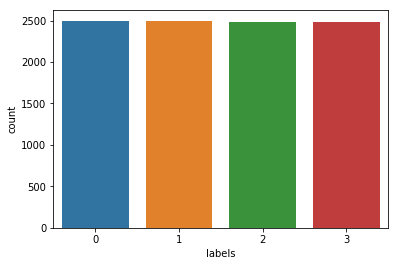

In [12]:
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

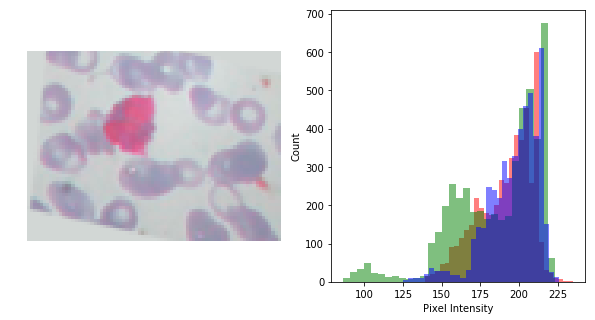

In [13]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[5])

In [14]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

X_train_2=np.array(X_train_2)
X_train_2=X_train_2/255.0

X_test_2=np.array(X_test_2)
X_test_2=X_test_2/255.0

In [15]:
X_train.shape

(9957, 60, 80, 3)

In [16]:
img_rows, img_cols, img_num_channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]
input_shape = (img_rows, img_cols, img_num_channels)
num_classes = len(y_trainHot[0])
print("input shape:", input_shape)
print("num classes:", num_classes)

input shape: (60, 80, 3)
num classes: 4


In [17]:
def build_keras_model(model_name, num_classes, input_shape):
    if model_name == 'vgg16':
        base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'inception_v3':
        base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    else:        
        return

    for layer in base_model.layers:
        layer.trainable = False
    
    # x = base_model.output
    # x = GlobalAveragePooling2D()(x)
    # x = Dense(1024, activation='relu')(x)
    # predictions = Dense(num_classes, activation='softmax')(x)

    # model = Model(inputs=base_model.input, outputs=predictions)
    
    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    # add_model.add(Flatten(input_shape=input_shape))
    add_model.add(Dense(512, activation='relu'))
    add_model.add(Dropout(0.5))
    add_model.add(Dense(num_classes, activation='softmax'))
        
    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

    return model

In [49]:
def build_vgg16_model(num_classes, input_shape):
    return build_keras_model('vgg16', num_classes, input_shape)

In [18]:
def build_baseline_model(num_classes, input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,strides=1))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [19]:
def build_our_model(num_classes, input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,strides=1))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [20]:
def build_our_model_2(num_classes, input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,strides=1))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [21]:
def build_lenet5_model(num_classes, input_shape):
    model = Sequential()
    # For an explanation on conv layers see http://cs231n.github.io/convolutional-networks/#conv
    # By default the stride/subsample is 1 and there is no zero-padding.
    # If you want zero-padding add a ZeroPadding layer or, if stride is 1 use border_mode="same"
    model.add(Conv2D(12, kernel_size=(5, 5), activation = 'relu', input_shape=input_shape, init='he_normal'))

    # For an explanation on pooling layers see http://cs231n.github.io/convolutional-networks/#pool
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(25, kernel_size=(5, 5), activation = 'relu', init='he_normal'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the 3D output to 1D tensor for a fully connected layer to accept the input
    model.add(Flatten())
    model.add(Dense(180, activation = 'relu', init='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = 'relu', init='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax', init='he_normal')) #Last layer with one output per class

    return model

In [33]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    
    # try to add 'loss' to see the loss learning curve
    filt = ['acc'] 
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

    
def plot_learning_curve(history):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(2,1,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [23]:
def train_model(model, x_train, y_train, x_test, y_test, learning_rate=1.0, lr_decay=0,
                metrics=['accuracy'], batch_size=100, epochs=30, shift_fraction=0.1, rotation_range=10, 
                shift_range=0.1, horizontal_flip=True, vertical_flip=False, optimizer='Adadelta',
                save_dir='./result'):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """

    # callbacks
    BestCheckpoint = ModelCheckpoint(save_dir + '/weights-best.h5', monitor='val_acc',
                                           save_best_only=True, save_weights_only=True, verbose=0)

    # compile the model
    if optimizer == 'Adadelta':
        optimizer_obj = Adadelta(lr=learning_rate, decay=lr_decay)
    elif optimizer == 'Adam':
        optimizer_obj = Adam(lr=learning_rate, decay=lr_decay)
    elif optimizer == 'SGD':
        optimizer_obj = SGD(lr=learning_rate, decay=lr_decay)
        
    model.compile(optimizer=optimizer_obj, loss=['categorical_crossentropy'], metrics=['accuracy'])

    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=rotation_range,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=shift_range,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=shift_range,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=horizontal_flip,  # randomly flip images
        vertical_flip=vertical_flip)  # randomly flip images
    
    history = model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size), 
        steps_per_epoch=len(x_train) / batch_size, 
        epochs=epochs, 
        validation_data = [x_test, y_test],
        callbacks = [TQDMNotebookCallback(leave_inner=True, leave_outer=True), BestCheckpoint, MetricsCheckpoint('logs')],
        verbose=0
    )
    
    # reload the model with the best weight
    model.load_weights(save_dir + '/weights-best.h5')
    
    # compile the model
    if optimizer == 'Adadelta':
        optimizer_obj = Adadelta(lr=learning_rate, decay=lr_decay)
    elif optimizer == 'Adam':
        optimizer_obj = Adam(lr=learning_rate, decay=lr_decay)
    elif optimizer == 'SGD':
        optimizer_obj = SGD(lr=learning_rate, decay=lr_decay)
        
    model.compile(optimizer=optimizer_obj, loss=['categorical_crossentropy'], metrics=['accuracy'])

    return history

In [24]:
def test_model(model, x_test, y_test, history):
    score = model.evaluate(x_test, y_test, verbose=True)
    print('Keras Test Accuracy:', score[1],'\n')
    y_pred = model.predict(x_test)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(y_test,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()

In [40]:
def runModel(x_train, y_train, x_test, y_test, build_model_callback, 
             save_dir='./result_ourself2', optimizer='Adadelta',
             epochs=30, batch_size=32, learning_rate=1.0, lr_decay=0.0, 
             shift_fraction=0.1, rotation_range=10, shift_range=0.1, 
             horizontal_flip=True, vertical_flip=False):
    
    num_classes = len(y_train[0])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_model_callback(num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        shift_fraction=shift_fraction, rotation_range=rotation_range, shift_range=shift_range, 
        horizontal_flip=horizontal_flip, vertical_flip=vertical_flip, optimizer=optimizer,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    print()
    test_model(model, x_test, y_test, history)

HBox(children=(IntProgress(value=0, description='Training', max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=311), HTML(value='')))


2487/2487 [==============================] - ETA: 16 - ETA: 2 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 315us/step
Keras Test Accuracy: 0.8620828309114745 


             precision    recall  f1-score   support

 NEUTROPHIL       0.68      0.91      0.78       624
 EOSINOPHIL       0.93      0.79      0.86       623
   MONOCYTE       0.95      0.75      0.84       620
 LYMPHOCYTE       0.97      1.00      0.99       620

avg / total       0.88      0.86      0.86      2487



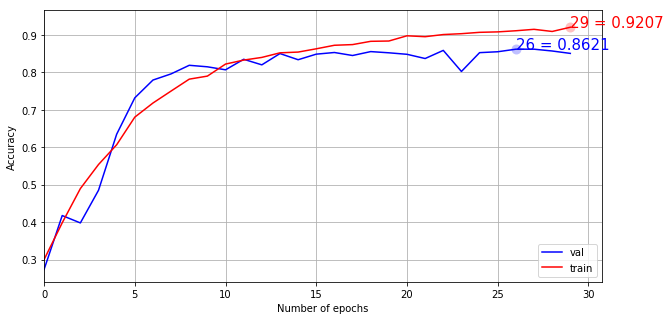

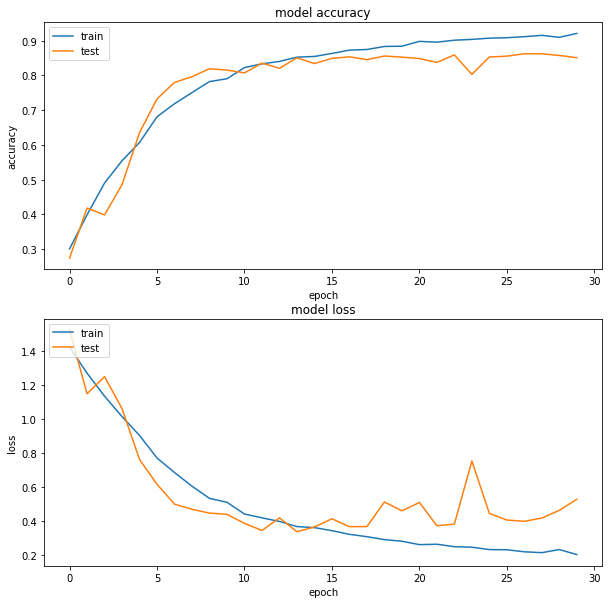

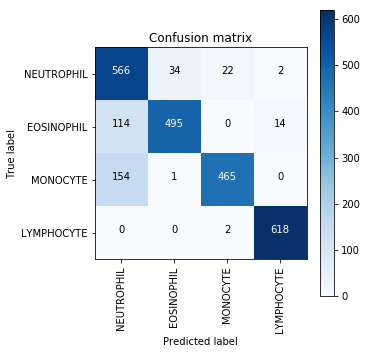

In [41]:
# run baseline model without black background
runModel(X_train, y_trainHot, X_test, y_testHot, build_model_callback=build_baseline_model, save_dir='./result_baseline_noblack')

HBox(children=(IntProgress(value=0, description='Training', max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=311), HTML(value='')))


2487/2487 [==============================] - ETA: 19 - ETA: 2 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 350us/step
Keras Test Accuracy: 0.8528347407472532 


             precision    recall  f1-score   support

 NEUTROPHIL       0.67      0.86      0.75       624
 EOSINOPHIL       0.84      0.81      0.83       623
   MONOCYTE       0.99      0.75      0.85       620
 LYMPHOCYTE       1.00      0.99      1.00       620

avg / total       0.87      0.85      0.86      2487



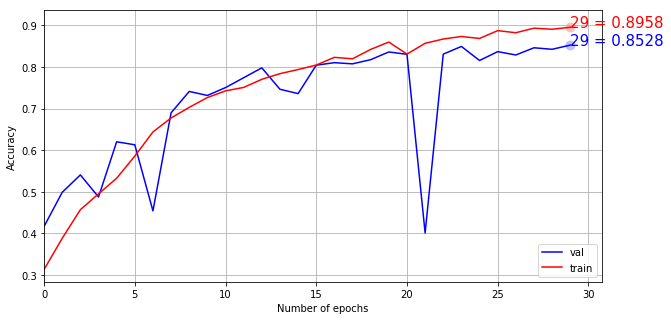

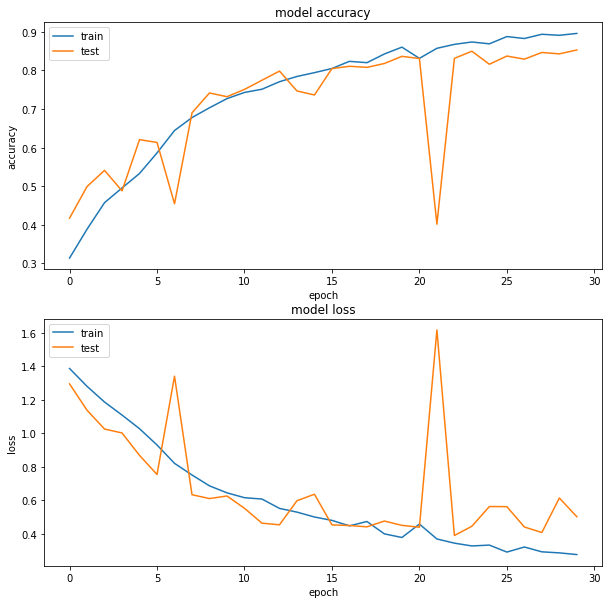

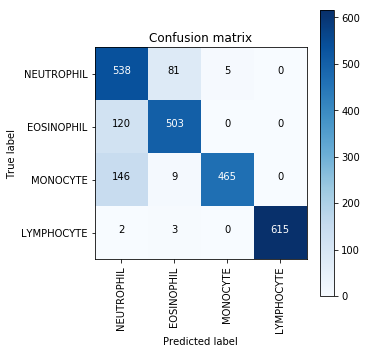

In [42]:
# run baseline model with black background
runModel(X_train_2, y_trainHot_2, X_test_2, y_testHot_2, build_model_callback=build_baseline_model, save_dir='./result_baseline_black')

HBox(children=(IntProgress(value=0, description='Training', max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=311), HTML(value='')))


2487/2487 [==============================] - ETA: 23 - ETA: 5 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 507us/step
Keras Test Accuracy: 0.897064736558579 


             precision    recall  f1-score   support

 NEUTROPHIL       0.88      0.74      0.80       624
 EOSINOPHIL       0.81      0.92      0.86       623
   MONOCYTE       0.97      0.92      0.95       620
 LYMPHOCYTE       0.95      1.00      0.97       620

avg / total       0.90      0.90      0.90      2487



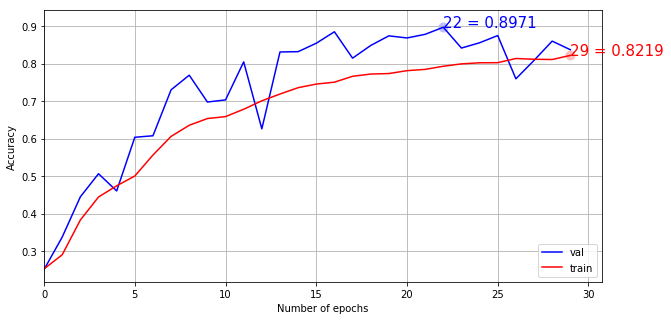

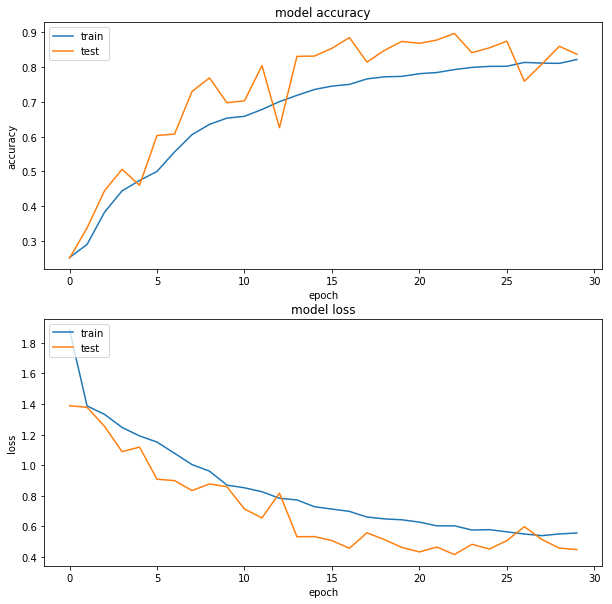

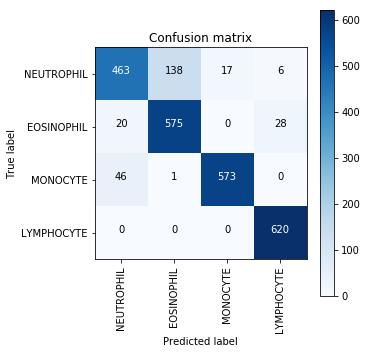

In [43]:
# run our model without black background
runModel(X_train, y_trainHot, X_test, y_testHot, build_model_callback=build_our_model_2, save_dir='./result_ourself_noblack')

HBox(children=(IntProgress(value=0, description='Training', max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=311), HTML(value='')))


2487/2487 [==============================] - ETA: 24 - ETA: 4 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 547us/step
Keras Test Accuracy: 0.8729392841104815 


             precision    recall  f1-score   support

 NEUTROPHIL       0.69      0.88      0.78       624
 EOSINOPHIL       0.89      0.86      0.87       623
   MONOCYTE       0.99      0.75      0.85       620
 LYMPHOCYTE       1.00      1.00      1.00       620

avg / total       0.89      0.87      0.88      2487



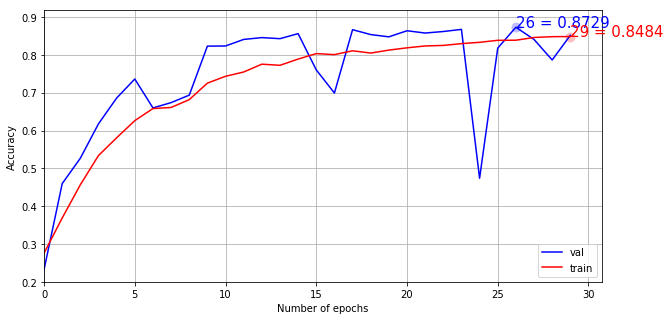

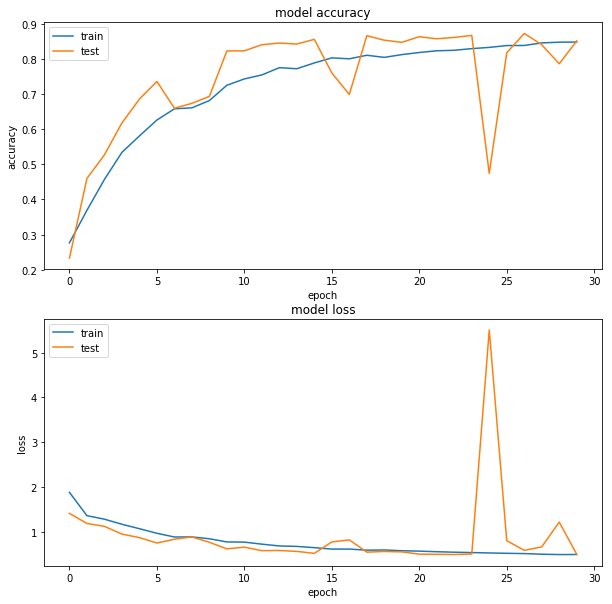

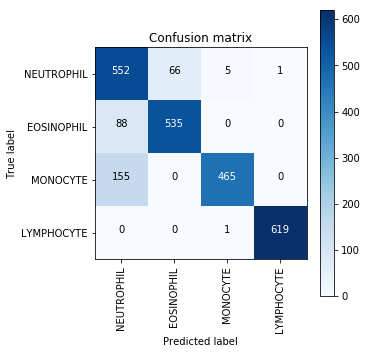

In [44]:
# run our model with black background
runModel(X_train_2, y_trainHot_2, X_test_2, y_testHot_2, build_model_callback=build_our_model_2, save_dir='./result_ourself_black')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, kernel_size=(5, 5), activation="relu", input_shape=(60, 80, 3..., kernel_initializer="he_normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(25, kernel_size=(5, 5), activation="relu", kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(180, activation="relu", kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Dense` call 

HBox(children=(IntProgress(value=0, description='Training', max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=311), HTML(value='')))


2487/2487 [==============================] - ETA: 59 - ETA: 6 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 515us/step
Keras Test Accuracy: 0.7917169282414321 


             precision    recall  f1-score   support

 NEUTROPHIL       0.66      0.77      0.71       624
 EOSINOPHIL       0.66      0.68      0.67       623
   MONOCYTE       0.97      0.75      0.85       620
 LYMPHOCYTE       0.93      0.97      0.95       620

avg / total       0.81      0.79      0.79      2487



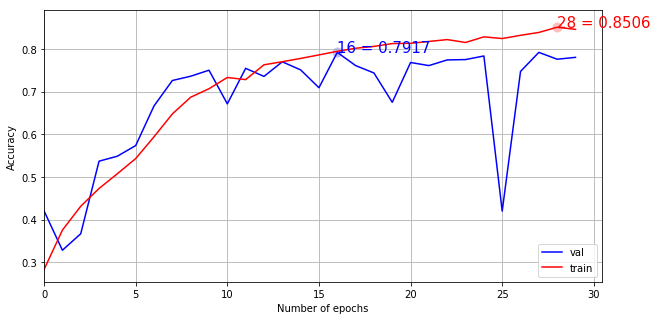

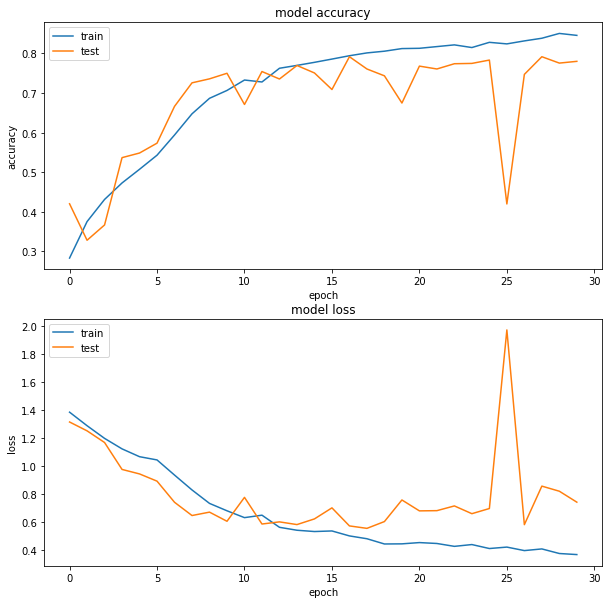

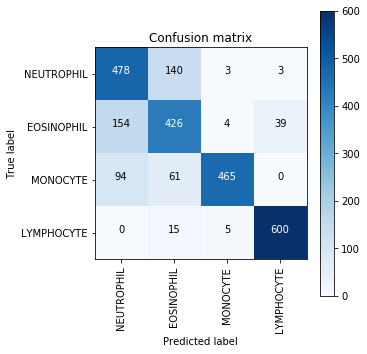

In [58]:
# run Lenet 5 without black background
runModel(X_train, y_trainHot, X_test, y_testHot, build_model_callback=build_lenet5_model, save_dir='./result_lenet5_noblack')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, kernel_size=(5, 5), activation="relu", input_shape=(60, 80, 3..., kernel_initializer="he_normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(25, kernel_size=(5, 5), activation="relu", kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(180, activation="relu", kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Dense` call 

HBox(children=(IntProgress(value=0, description='Training', max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=311), HTML(value='')))


2487/2487 [==============================] - ETA: 1: - ETA: 5s - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 518us/step
Keras Test Accuracy: 0.701648572505503 


             precision    recall  f1-score   support

 NEUTROPHIL       0.52      0.72      0.60       624
 EOSINOPHIL       0.51      0.36      0.42       623
   MONOCYTE       0.95      0.76      0.85       620
 LYMPHOCYTE       0.88      0.96      0.92       620

avg / total       0.71      0.70      0.70      2487



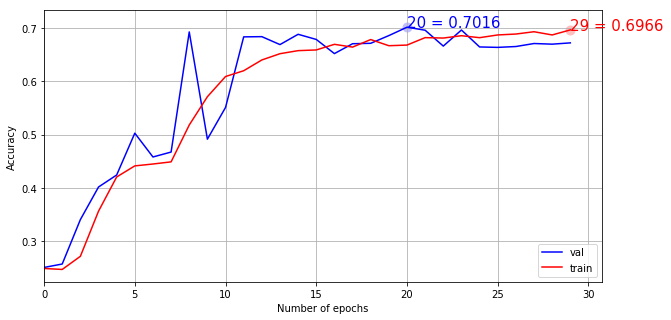

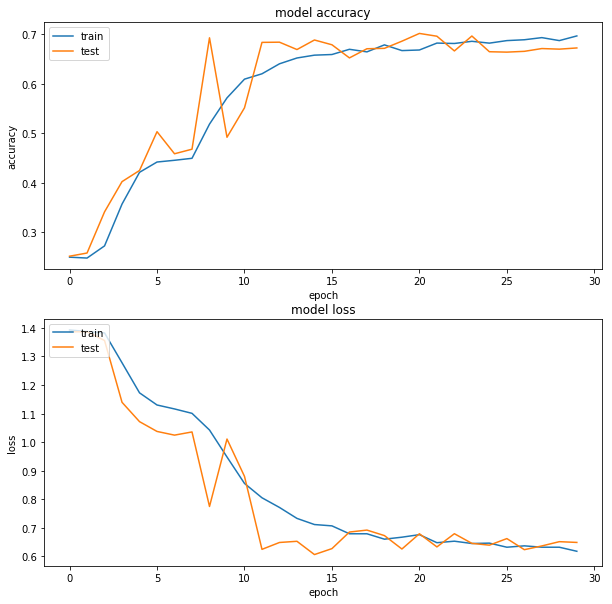

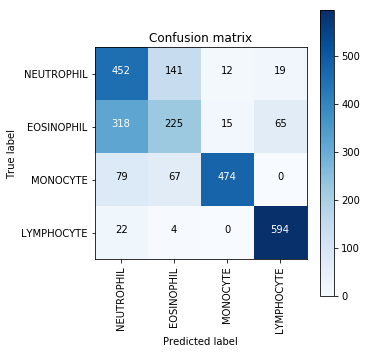

In [59]:
# run Lenet 5 with black background
runModel(X_train_2, y_trainHot_2, X_test_2, y_testHot_2, build_model_callback=build_lenet5_model, save_dir='./result_lenet5_black')

HBox(children=(IntProgress(value=0, description='Training', max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=311), HTML(value='')))


2487/2487 [==============================] - ETA: 1: - ETA: 17s - ETA: 10 - ETA: 7 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 1ms/step
Keras Test Accuracy: 0.6654603940011221 


             precision    recall  f1-score   support

 NEUTROPHIL       0.64      0.51      0.57       624
 EOSINOPHIL       0.57      0.60      0.58       623
   MONOCYTE       0.63      0.76      0.69       620
 LYMPHOCYTE       0.85      0.79      0.82       620

avg / total       0.67      0.67      0.66      2487



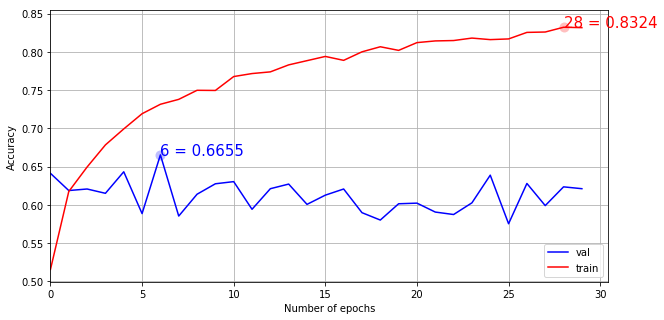

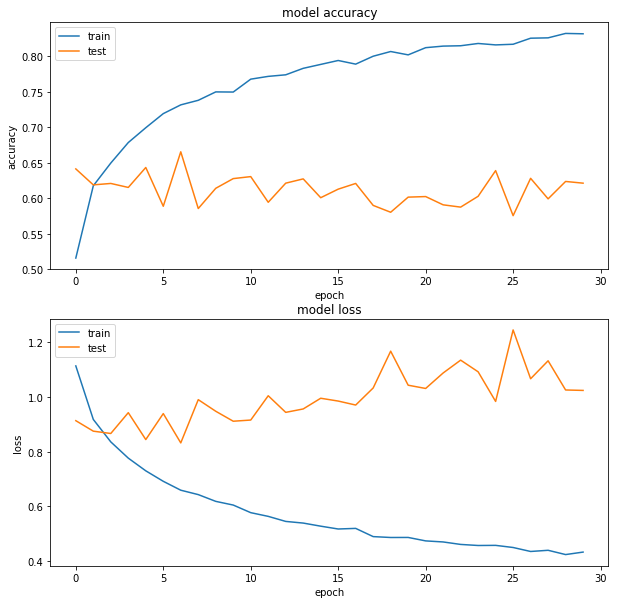

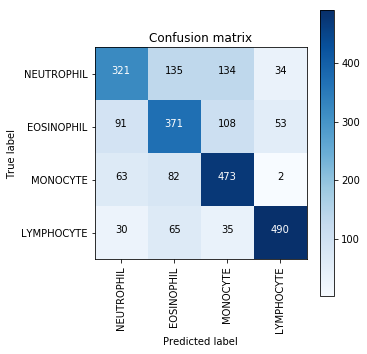

In [61]:
# run VGG 16 without black background
runModel(X_train, y_trainHot, X_test, y_testHot, build_model_callback=build_vgg16_model, save_dir='./result_vgg16_noblack')

HBox(children=(IntProgress(value=0, description='Training', max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=311), HTML(value='')))


2487/2487 [==============================] - ETA: 1: - ETA: 17s - ETA: 10 - ETA: 7 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 1ms/step
Keras Test Accuracy: 0.6260554884924772 


             precision    recall  f1-score   support

 NEUTROPHIL       0.57      0.60      0.59       624
 EOSINOPHIL       0.53      0.48      0.50       623
   MONOCYTE       0.62      0.58      0.60       620
 LYMPHOCYTE       0.77      0.85      0.80       620

avg / total       0.62      0.63      0.62      2487



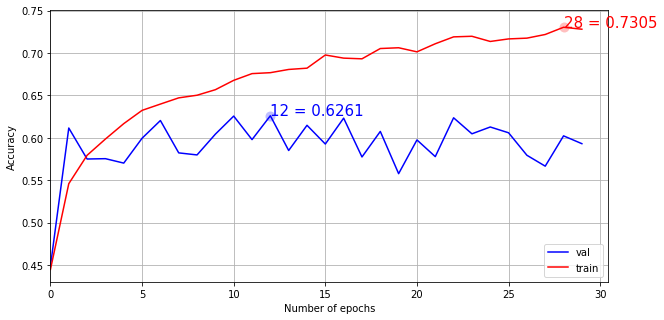

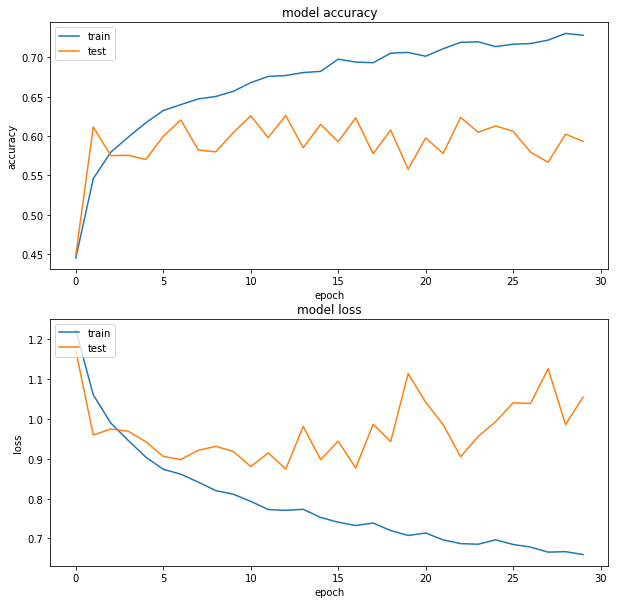

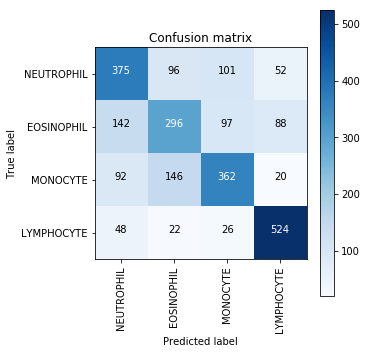

In [62]:
# run VGG 16 with black background
runModel(X_train_2, y_trainHot_2, X_test_2, y_testHot_2, build_model_callback=build_vgg16_model, save_dir='./result_vgg16_black')

# Grid Search

HBox(children=(IntProgress(value=0, description='Training', max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=311), HTML(value='')))


2487/2487 [==============================] - ETA: 44 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 654us/step
Keras Test Accuracy: 0.8307197428775399 


             precision    recall  f1-score   support

 NEUTROPHIL       0.64      0.76      0.70       624
 EOSINOPHIL       0.79      0.81      0.80       623
   MONOCYTE       0.97      0.75      0.85       620
 LYMPHOCYTE       0.98      1.00      0.99       620

avg / total       0.85      0.83      0.83      2487



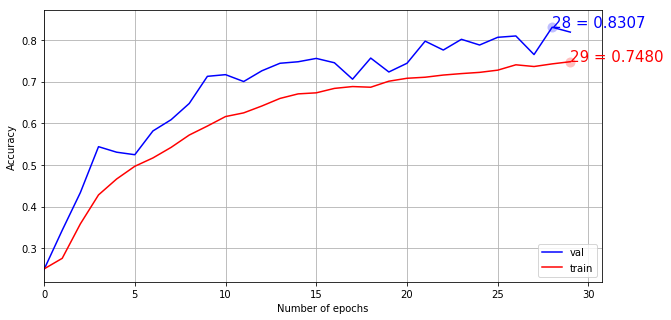

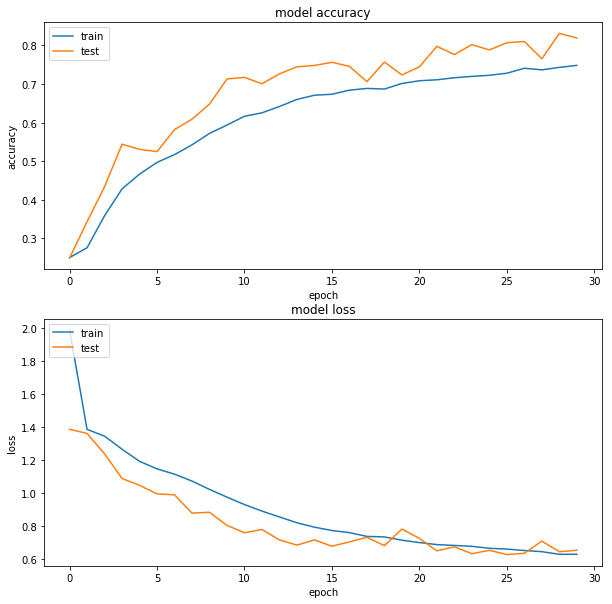

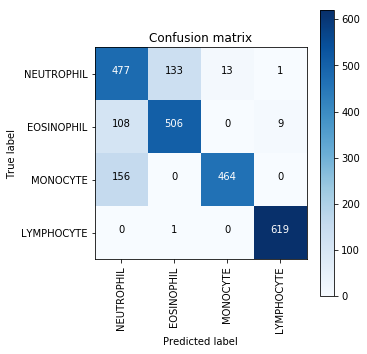

In [53]:
# use Our model with adadelta optimizer, lr=1.0, lr_decay=0.001

runModel(X_train, y_trainHot, X_test, y_testHot, 
         optimizer='Adadelta', learning_rate=1.0, lr_decay=0.001, 
         build_model_callback=build_our_model_2, 
         save_dir='./result_ourself_noblack_decay_0_001')

HBox(children=(IntProgress(value=0, description='Training', max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=311), HTML(value='')))


2487/2487 [==============================] - ETA: 47 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 662us/step
Keras Test Accuracy: 0.8745476476006303 


             precision    recall  f1-score   support

 NEUTROPHIL       0.70      0.90      0.79       624
 EOSINOPHIL       0.90      0.86      0.88       623
   MONOCYTE       0.97      0.75      0.85       620
 LYMPHOCYTE       1.00      0.99      0.99       620

avg / total       0.89      0.87      0.88      2487



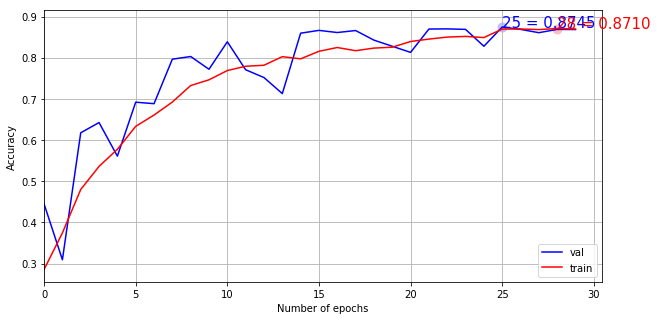

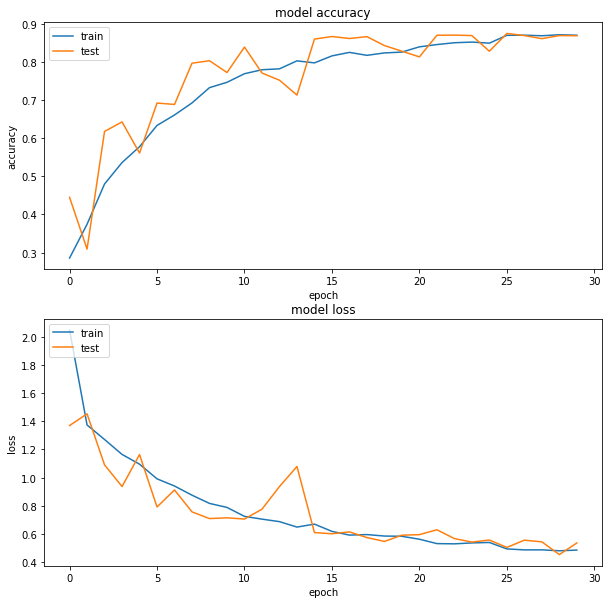

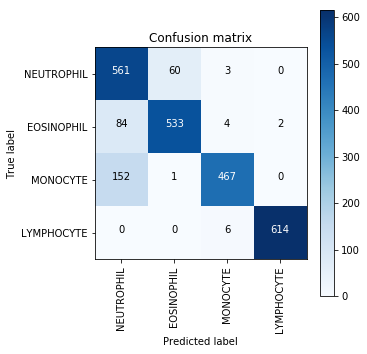

In [54]:
# use Our model with adadelta optimizer, lr=0.8, lr_decay=0.0

runModel(X_train, y_trainHot, X_test, y_testHot, 
         optimizer='Adadelta', learning_rate=0.8, lr_decay=0.0, 
         build_model_callback=build_our_model_2, 
         save_dir='./result_ourself_noblack_lr_0_8')

HBox(children=(IntProgress(value=0, description='Training', max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 30', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 35', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 37', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 38', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 40', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 43', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 46', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=311), HTML(value='')))


2487/2487 [==============================] - ETA: 1: - ETA: 31s - ETA: 24 - ETA: 16 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 1ms/step
Keras Test Accuracy: 0.8942501003549528 


             precision    recall  f1-score   support

 NEUTROPHIL       0.77      0.84      0.80       624
 EOSINOPHIL       0.86      0.99      0.92       623
   MONOCYTE       0.99      0.75      0.85       620
 LYMPHOCYTE       1.00      1.00      1.00       620

avg / total       0.90      0.89      0.89      2487



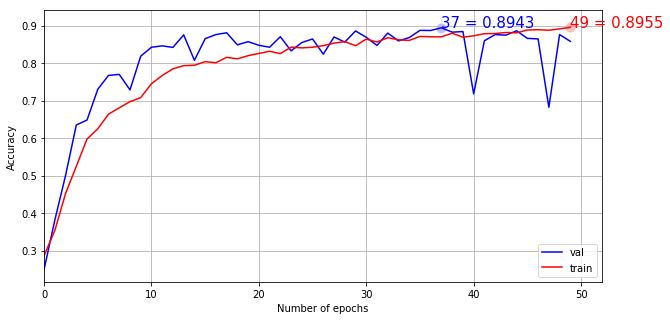

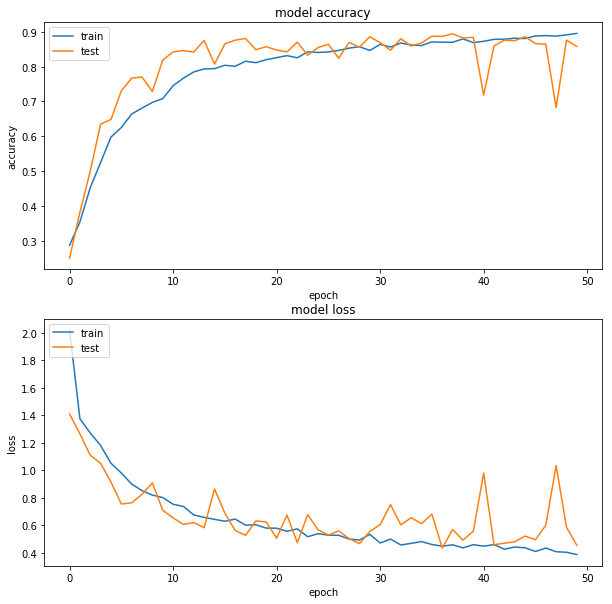

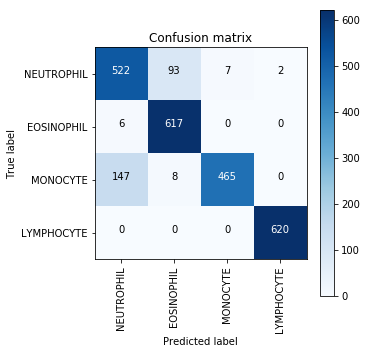

In [55]:
# use Our model with adadelta optimizer, epochs=50, lr=0.8, lr_decay=0.0

runModel(X_train, y_trainHot, X_test, y_testHot, 
         optimizer='Adadelta', epochs=50, learning_rate=0.8, lr_decay=0.0, 
         build_model_callback=build_our_model_2, 
         save_dir='./result_ourself_noblack_epochs_50_lr_0_8')

HBox(children=(IntProgress(value=0, description='Training', max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 30', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 35', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 37', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 38', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 40', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 43', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 46', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=311), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=311), HTML(value='')))


2487/2487 [==============================] - ETA: 54 - ETA: 11 - ETA: 6 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 712us/step
Keras Test Accuracy: 0.8930438278332071 


             precision    recall  f1-score   support

 NEUTROPHIL       0.76      0.84      0.80       624
 EOSINOPHIL       0.86      0.98      0.92       623
   MONOCYTE       1.00      0.75      0.85       620
 LYMPHOCYTE       1.00      1.00      1.00       620

avg / total       0.90      0.89      0.89      2487



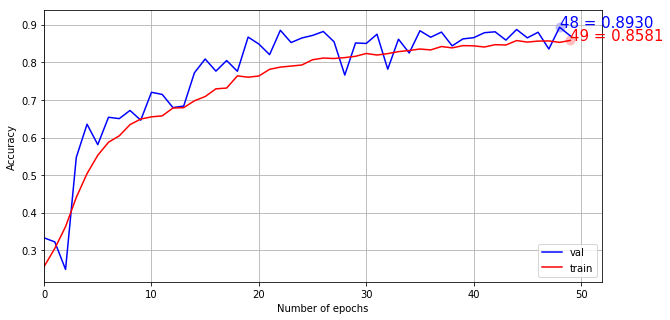

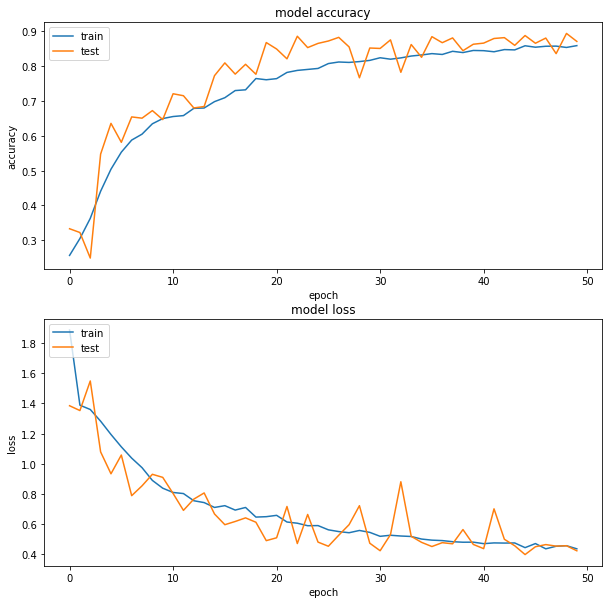

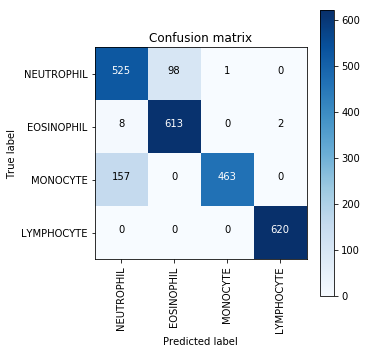

In [56]:
# use Our model with adadelta optimizer, epochs=50, lr=1.0, lr_decay=0.0

runModel(X_train, y_trainHot, X_test, y_testHot, 
         optimizer='Adadelta', epochs=50, learning_rate=1.0, lr_decay=0.0, 
         build_model_callback=build_our_model_2, 
         save_dir='./result_ourself_noblack_epochs_50')

In [ ]:
# use adam optimizer

runOurModel2Optimized(X_train, y_trainHot, X_test, y_testHot, optimizer='Adam', learning_rate=0.001, lr_decay=0.0)

In [ ]:
# use SGD optimizer

runOurModel2Optimized(X_train, y_trainHot, X_test, y_testHot, optimizer='SGD', learning_rate=0.01, lr_decay=0.0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, kernel_size=(5, 5), activation="relu", input_shape=(60, 80, 3..., kernel_initializer="he_normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(25, kernel_size=(5, 5), activation="relu", kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(180, activation="relu", kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Dense` call 

Epoch 1/30
312/311 [==============================] - ETA: 2:55 - loss: 2.2355 - acc: 0.156 - ETA: 27s - loss: 1.8617 - acc: 0.151 - ETA: 15s - loss: 1.6498 - acc: 0.18 - ETA: 14s - loss: 1.6141 - acc: 0.19 - ETA: 13s - loss: 1.5883 - acc: 0.19 - ETA: 13s - loss: 1.5683 - acc: 0.19 - ETA: 12s - loss: 1.5515 - acc: 0.20 - ETA: 12s - loss: 1.5371 - acc: 0.20 - ETA: 12s - loss: 1.5253 - acc: 0.21 - ETA: 11s - loss: 1.5160 - acc: 0.21 - ETA: 11s - loss: 1.5075 - acc: 0.21 - ETA: 11s - loss: 1.4994 - acc: 0.22 - ETA: 11s - loss: 1.4928 - acc: 0.22 - ETA: 11s - loss: 1.4870 - acc: 0.22 - ETA: 10s - loss: 1.4813 - acc: 0.22 - ETA: 10s - loss: 1.4762 - acc: 0.23 - ETA: 10s - loss: 1.4721 - acc: 0.22 - ETA: 10s - loss: 1.4679 - acc: 0.22 - ETA: 10s - loss: 1.4641 - acc: 0.23 - ETA: 10s - loss: 1.4609 - acc: 0.23 - ETA: 10s - loss: 1.4585 - acc: 0.23 - ETA: 9s - loss: 1.4551 - acc: 0.2347 - ETA: 9s - loss: 1.4529 - acc: 0.235 - ETA: 9s - loss: 1.4511 - acc: 0.235 - ETA: 9s - loss: 1.4482 - acc: 

312/311 [==============================] - ETA: 3s - loss: 1.4466 - acc: 0.187 - ETA: 3s - loss: 1.3328 - acc: 0.322 - ETA: 2s - loss: 1.3170 - acc: 0.333 - ETA: 3s - loss: 1.2994 - acc: 0.354 - ETA: 4s - loss: 1.3096 - acc: 0.349 - ETA: 4s - loss: 1.3061 - acc: 0.348 - ETA: 5s - loss: 1.2984 - acc: 0.351 - ETA: 5s - loss: 1.2807 - acc: 0.368 - ETA: 5s - loss: 1.2780 - acc: 0.365 - ETA: 5s - loss: 1.2779 - acc: 0.362 - ETA: 6s - loss: 1.2684 - acc: 0.369 - ETA: 6s - loss: 1.2620 - acc: 0.374 - ETA: 6s - loss: 1.2679 - acc: 0.374 - ETA: 6s - loss: 1.2651 - acc: 0.377 - ETA: 6s - loss: 1.2654 - acc: 0.378 - ETA: 6s - loss: 1.2662 - acc: 0.379 - ETA: 6s - loss: 1.2646 - acc: 0.380 - ETA: 6s - loss: 1.2601 - acc: 0.382 - ETA: 6s - loss: 1.2566 - acc: 0.384 - ETA: 6s - loss: 1.2561 - acc: 0.385 - ETA: 6s - loss: 1.2492 - acc: 0.388 - ETA: 6s - loss: 1.2555 - acc: 0.385 - ETA: 6s - loss: 1.2586 - acc: 0.384 - ETA: 6s - loss: 1.2566 - acc: 0.386 - ETA: 6s - loss: 1.2570 - acc: 0.386 - ETA: 6s

312/311 [==============================] - ETA: 3s - loss: 1.0769 - acc: 0.500 - ETA: 3s - loss: 1.0720 - acc: 0.494 - ETA: 2s - loss: 1.0471 - acc: 0.513 - ETA: 3s - loss: 1.0358 - acc: 0.517 - ETA: 3s - loss: 1.0309 - acc: 0.526 - ETA: 4s - loss: 1.0252 - acc: 0.532 - ETA: 4s - loss: 1.0573 - acc: 0.518 - ETA: 5s - loss: 1.0722 - acc: 0.507 - ETA: 5s - loss: 1.0681 - acc: 0.508 - ETA: 5s - loss: 1.0733 - acc: 0.503 - ETA: 5s - loss: 1.0756 - acc: 0.503 - ETA: 5s - loss: 1.0703 - acc: 0.509 - ETA: 6s - loss: 1.0620 - acc: 0.513 - ETA: 6s - loss: 1.0522 - acc: 0.519 - ETA: 6s - loss: 1.0467 - acc: 0.518 - ETA: 6s - loss: 1.0375 - acc: 0.521 - ETA: 6s - loss: 1.0353 - acc: 0.522 - ETA: 6s - loss: 1.0364 - acc: 0.523 - ETA: 6s - loss: 1.0320 - acc: 0.523 - ETA: 6s - loss: 1.0332 - acc: 0.525 - ETA: 6s - loss: 1.0459 - acc: 0.516 - ETA: 6s - loss: 1.0542 - acc: 0.512 - ETA: 6s - loss: 1.0543 - acc: 0.508 - ETA: 6s - loss: 1.0528 - acc: 0.512 - ETA: 6s - loss: 1.0483 - acc: 0.512 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 1.0791 - acc: 0.468 - ETA: 2s - loss: 0.9968 - acc: 0.509 - ETA: 2s - loss: 0.9864 - acc: 0.539 - ETA: 3s - loss: 0.9827 - acc: 0.562 - ETA: 4s - loss: 0.9653 - acc: 0.575 - ETA: 4s - loss: 0.9543 - acc: 0.581 - ETA: 5s - loss: 0.9615 - acc: 0.575 - ETA: 5s - loss: 0.9616 - acc: 0.570 - ETA: 5s - loss: 0.9510 - acc: 0.576 - ETA: 5s - loss: 0.9445 - acc: 0.577 - ETA: 6s - loss: 0.9343 - acc: 0.577 - ETA: 6s - loss: 0.9305 - acc: 0.574 - ETA: 6s - loss: 0.9316 - acc: 0.574 - ETA: 6s - loss: 0.9274 - acc: 0.578 - ETA: 6s - loss: 0.9290 - acc: 0.575 - ETA: 6s - loss: 0.9233 - acc: 0.575 - ETA: 6s - loss: 0.9164 - acc: 0.579 - ETA: 6s - loss: 0.9138 - acc: 0.583 - ETA: 6s - loss: 0.9132 - acc: 0.582 - ETA: 6s - loss: 0.9201 - acc: 0.580 - ETA: 6s - loss: 0.9199 - acc: 0.578 - ETA: 6s - loss: 0.9246 - acc: 0.577 - ETA: 6s - loss: 0.9278 - acc: 0.577 - ETA: 6s - loss: 0.9279 - acc: 0.577 - ETA: 6s - loss: 0.9242 - acc: 0.578 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 1.1461 - acc: 0.531 - ETA: 2s - loss: 0.9585 - acc: 0.593 - ETA: 2s - loss: 0.8997 - acc: 0.629 - ETA: 3s - loss: 0.9004 - acc: 0.628 - ETA: 4s - loss: 0.8913 - acc: 0.628 - ETA: 4s - loss: 0.8748 - acc: 0.631 - ETA: 5s - loss: 0.8775 - acc: 0.629 - ETA: 5s - loss: 0.8675 - acc: 0.625 - ETA: 5s - loss: 0.8517 - acc: 0.628 - ETA: 5s - loss: 0.8553 - acc: 0.626 - ETA: 6s - loss: 0.8569 - acc: 0.621 - ETA: 6s - loss: 0.8516 - acc: 0.624 - ETA: 6s - loss: 0.8457 - acc: 0.624 - ETA: 6s - loss: 0.8418 - acc: 0.625 - ETA: 6s - loss: 0.8464 - acc: 0.627 - ETA: 6s - loss: 0.8484 - acc: 0.625 - ETA: 6s - loss: 0.8418 - acc: 0.628 - ETA: 6s - loss: 0.8431 - acc: 0.628 - ETA: 6s - loss: 0.8454 - acc: 0.627 - ETA: 6s - loss: 0.8438 - acc: 0.625 - ETA: 6s - loss: 0.8396 - acc: 0.628 - ETA: 6s - loss: 0.8344 - acc: 0.630 - ETA: 6s - loss: 0.8332 - acc: 0.631 - ETA: 6s - loss: 0.8289 - acc: 0.633 - ETA: 6s - loss: 0.8223 - acc: 0.633 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 0.8618 - acc: 0.531 - ETA: 2s - loss: 0.7163 - acc: 0.616 - ETA: 2s - loss: 0.7030 - acc: 0.644 - ETA: 3s - loss: 0.7083 - acc: 0.640 - ETA: 4s - loss: 0.7276 - acc: 0.631 - ETA: 4s - loss: 0.7257 - acc: 0.635 - ETA: 4s - loss: 0.7282 - acc: 0.633 - ETA: 5s - loss: 0.7285 - acc: 0.635 - ETA: 5s - loss: 0.7384 - acc: 0.637 - ETA: 5s - loss: 0.7447 - acc: 0.636 - ETA: 5s - loss: 0.7550 - acc: 0.634 - ETA: 6s - loss: 0.7471 - acc: 0.634 - ETA: 6s - loss: 0.7484 - acc: 0.634 - ETA: 6s - loss: 0.7731 - acc: 0.628 - ETA: 6s - loss: 0.7805 - acc: 0.623 - ETA: 6s - loss: 0.7818 - acc: 0.623 - ETA: 6s - loss: 0.7736 - acc: 0.626 - ETA: 6s - loss: 0.7711 - acc: 0.628 - ETA: 6s - loss: 0.7599 - acc: 0.633 - ETA: 6s - loss: 0.7614 - acc: 0.632 - ETA: 6s - loss: 0.7579 - acc: 0.634 - ETA: 6s - loss: 0.7557 - acc: 0.637 - ETA: 6s - loss: 0.7558 - acc: 0.637 - ETA: 6s - loss: 0.7484 - acc: 0.640 - ETA: 6s - loss: 0.7465 - acc: 0.643 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 0.4869 - acc: 0.718 - ETA: 2s - loss: 0.6733 - acc: 0.674 - ETA: 2s - loss: 0.6203 - acc: 0.701 - ETA: 3s - loss: 0.6448 - acc: 0.697 - ETA: 4s - loss: 0.6380 - acc: 0.694 - ETA: 4s - loss: 0.6366 - acc: 0.695 - ETA: 5s - loss: 0.6505 - acc: 0.684 - ETA: 5s - loss: 0.6486 - acc: 0.683 - ETA: 5s - loss: 0.6549 - acc: 0.678 - ETA: 6s - loss: 0.6542 - acc: 0.678 - ETA: 6s - loss: 0.6550 - acc: 0.683 - ETA: 6s - loss: 0.6607 - acc: 0.685 - ETA: 6s - loss: 0.6657 - acc: 0.686 - ETA: 6s - loss: 0.6752 - acc: 0.681 - ETA: 6s - loss: 0.6709 - acc: 0.684 - ETA: 6s - loss: 0.6666 - acc: 0.682 - ETA: 6s - loss: 0.6676 - acc: 0.681 - ETA: 6s - loss: 0.6686 - acc: 0.681 - ETA: 6s - loss: 0.6660 - acc: 0.684 - ETA: 7s - loss: 0.6714 - acc: 0.683 - ETA: 7s - loss: 0.6815 - acc: 0.678 - ETA: 7s - loss: 0.6921 - acc: 0.672 - ETA: 7s - loss: 0.6890 - acc: 0.672 - ETA: 7s - loss: 0.6878 - acc: 0.674 - ETA: 7s - loss: 0.7003 - acc: 0.671 - ETA: 7s

312/311 [==============================] - ETA: 2s - loss: 0.7440 - acc: 0.593 - ETA: 2s - loss: 0.6587 - acc: 0.660 - ETA: 2s - loss: 0.6461 - acc: 0.666 - ETA: 3s - loss: 0.6326 - acc: 0.681 - ETA: 4s - loss: 0.6490 - acc: 0.683 - ETA: 4s - loss: 0.6716 - acc: 0.679 - ETA: 5s - loss: 0.6654 - acc: 0.683 - ETA: 5s - loss: 0.6515 - acc: 0.691 - ETA: 5s - loss: 0.6447 - acc: 0.697 - ETA: 5s - loss: 0.6422 - acc: 0.700 - ETA: 6s - loss: 0.6372 - acc: 0.699 - ETA: 6s - loss: 0.6431 - acc: 0.694 - ETA: 6s - loss: 0.6403 - acc: 0.694 - ETA: 6s - loss: 0.6276 - acc: 0.701 - ETA: 6s - loss: 0.6273 - acc: 0.696 - ETA: 6s - loss: 0.6226 - acc: 0.700 - ETA: 6s - loss: 0.6159 - acc: 0.702 - ETA: 6s - loss: 0.6157 - acc: 0.704 - ETA: 6s - loss: 0.6402 - acc: 0.699 - ETA: 6s - loss: 0.6619 - acc: 0.693 - ETA: 6s - loss: 0.6589 - acc: 0.694 - ETA: 6s - loss: 0.6551 - acc: 0.699 - ETA: 6s - loss: 0.6521 - acc: 0.699 - ETA: 6s - loss: 0.6468 - acc: 0.702 - ETA: 6s - loss: 0.6412 - acc: 0.704 - ETA: 6s

312/311 [==============================] - ETA: 3s - loss: 0.5745 - acc: 0.750 - ETA: 2s - loss: 0.5579 - acc: 0.745 - ETA: 3s - loss: 0.6672 - acc: 0.700 - ETA: 3s - loss: 0.6122 - acc: 0.724 - ETA: 3s - loss: 0.5993 - acc: 0.730 - ETA: 4s - loss: 0.6168 - acc: 0.715 - ETA: 4s - loss: 0.6191 - acc: 0.713 - ETA: 5s - loss: 0.6062 - acc: 0.722 - ETA: 5s - loss: 0.6031 - acc: 0.724 - ETA: 5s - loss: 0.5830 - acc: 0.732 - ETA: 5s - loss: 0.5909 - acc: 0.731 - ETA: 5s - loss: 0.5848 - acc: 0.733 - ETA: 5s - loss: 0.5905 - acc: 0.728 - ETA: 6s - loss: 0.5890 - acc: 0.726 - ETA: 6s - loss: 0.5904 - acc: 0.725 - ETA: 6s - loss: 0.5872 - acc: 0.730 - ETA: 6s - loss: 0.5907 - acc: 0.728 - ETA: 6s - loss: 0.5902 - acc: 0.728 - ETA: 6s - loss: 0.5906 - acc: 0.726 - ETA: 6s - loss: 0.5852 - acc: 0.729 - ETA: 6s - loss: 0.5839 - acc: 0.731 - ETA: 6s - loss: 0.5813 - acc: 0.730 - ETA: 6s - loss: 0.5813 - acc: 0.730 - ETA: 6s - loss: 0.5836 - acc: 0.730 - ETA: 6s - loss: 0.5819 - acc: 0.732 - ETA: 6s

312/311 [==============================] - ETA: 3s - loss: 0.5593 - acc: 0.718 - ETA: 2s - loss: 0.5396 - acc: 0.741 - ETA: 3s - loss: 0.5506 - acc: 0.737 - ETA: 4s - loss: 0.5623 - acc: 0.736 - ETA: 4s - loss: 0.5605 - acc: 0.736 - ETA: 5s - loss: 0.5455 - acc: 0.746 - ETA: 5s - loss: 0.5556 - acc: 0.746 - ETA: 6s - loss: 0.5521 - acc: 0.751 - ETA: 6s - loss: 0.5487 - acc: 0.755 - ETA: 6s - loss: 0.5522 - acc: 0.753 - ETA: 6s - loss: 0.5697 - acc: 0.751 - ETA: 6s - loss: 0.5600 - acc: 0.753 - ETA: 6s - loss: 0.5657 - acc: 0.752 - ETA: 7s - loss: 0.5723 - acc: 0.744 - ETA: 7s - loss: 0.5712 - acc: 0.745 - ETA: 7s - loss: 0.5733 - acc: 0.745 - ETA: 7s - loss: 0.5766 - acc: 0.744 - ETA: 7s - loss: 0.5936 - acc: 0.735 - ETA: 7s - loss: 0.5923 - acc: 0.735 - ETA: 7s - loss: 0.5860 - acc: 0.739 - ETA: 7s - loss: 0.5826 - acc: 0.741 - ETA: 7s - loss: 0.5810 - acc: 0.741 - ETA: 7s - loss: 0.5759 - acc: 0.744 - ETA: 7s - loss: 0.5777 - acc: 0.742 - ETA: 7s - loss: 0.5844 - acc: 0.738 - ETA: 7s

312/311 [==============================] - ETA: 3s - loss: 0.3760 - acc: 0.781 - ETA: 4s - loss: 0.4877 - acc: 0.754 - ETA: 3s - loss: 0.5121 - acc: 0.735 - ETA: 4s - loss: 0.4818 - acc: 0.757 - ETA: 4s - loss: 0.4757 - acc: 0.768 - ETA: 5s - loss: 0.4873 - acc: 0.761 - ETA: 5s - loss: 0.4928 - acc: 0.764 - ETA: 5s - loss: 0.4830 - acc: 0.772 - ETA: 5s - loss: 0.4789 - acc: 0.780 - ETA: 6s - loss: 0.4815 - acc: 0.778 - ETA: 6s - loss: 0.4893 - acc: 0.780 - ETA: 6s - loss: 0.5008 - acc: 0.777 - ETA: 6s - loss: 0.4972 - acc: 0.778 - ETA: 6s - loss: 0.4979 - acc: 0.777 - ETA: 6s - loss: 0.4925 - acc: 0.781 - ETA: 6s - loss: 0.5031 - acc: 0.778 - ETA: 6s - loss: 0.5041 - acc: 0.773 - ETA: 6s - loss: 0.5158 - acc: 0.770 - ETA: 6s - loss: 0.5160 - acc: 0.768 - ETA: 6s - loss: 0.5133 - acc: 0.771 - ETA: 6s - loss: 0.5109 - acc: 0.769 - ETA: 6s - loss: 0.5043 - acc: 0.774 - ETA: 6s - loss: 0.5039 - acc: 0.776 - ETA: 6s - loss: 0.5041 - acc: 0.777 - ETA: 6s - loss: 0.5029 - acc: 0.776 - ETA: 6s

312/311 [==============================] - ETA: 4s - loss: 0.7066 - acc: 0.593 - ETA: 2s - loss: 0.6208 - acc: 0.699 - ETA: 3s - loss: 0.5487 - acc: 0.745 - ETA: 3s - loss: 0.5105 - acc: 0.773 - ETA: 4s - loss: 0.5072 - acc: 0.771 - ETA: 4s - loss: 0.5459 - acc: 0.764 - ETA: 5s - loss: 0.5488 - acc: 0.763 - ETA: 5s - loss: 0.5375 - acc: 0.768 - ETA: 5s - loss: 0.5381 - acc: 0.768 - ETA: 5s - loss: 0.5495 - acc: 0.766 - ETA: 6s - loss: 0.5684 - acc: 0.761 - ETA: 6s - loss: 0.5800 - acc: 0.755 - ETA: 6s - loss: 0.5730 - acc: 0.759 - ETA: 6s - loss: 0.5842 - acc: 0.758 - ETA: 6s - loss: 0.5825 - acc: 0.756 - ETA: 6s - loss: 0.5787 - acc: 0.762 - ETA: 6s - loss: 0.5886 - acc: 0.762 - ETA: 6s - loss: 0.5990 - acc: 0.760 - ETA: 6s - loss: 0.5976 - acc: 0.760 - ETA: 6s - loss: 0.5950 - acc: 0.760 - ETA: 6s - loss: 0.5940 - acc: 0.761 - ETA: 6s - loss: 0.5894 - acc: 0.761 - ETA: 6s - loss: 0.5871 - acc: 0.760 - ETA: 6s - loss: 0.5820 - acc: 0.763 - ETA: 6s - loss: 0.5758 - acc: 0.764 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 0.3200 - acc: 0.875 - ETA: 2s - loss: 0.4241 - acc: 0.803 - ETA: 2s - loss: 0.4461 - acc: 0.794 - ETA: 3s - loss: 0.4264 - acc: 0.797 - ETA: 4s - loss: 0.4256 - acc: 0.790 - ETA: 4s - loss: 0.4244 - acc: 0.792 - ETA: 5s - loss: 0.4405 - acc: 0.790 - ETA: 5s - loss: 0.4357 - acc: 0.794 - ETA: 5s - loss: 0.4637 - acc: 0.785 - ETA: 6s - loss: 0.4630 - acc: 0.784 - ETA: 6s - loss: 0.4576 - acc: 0.789 - ETA: 6s - loss: 0.4544 - acc: 0.792 - ETA: 6s - loss: 0.4565 - acc: 0.790 - ETA: 6s - loss: 0.4526 - acc: 0.793 - ETA: 6s - loss: 0.4461 - acc: 0.797 - ETA: 6s - loss: 0.4460 - acc: 0.798 - ETA: 6s - loss: 0.4415 - acc: 0.799 - ETA: 7s - loss: 0.4386 - acc: 0.802 - ETA: 7s - loss: 0.4443 - acc: 0.797 - ETA: 7s - loss: 0.4419 - acc: 0.800 - ETA: 7s - loss: 0.4404 - acc: 0.801 - ETA: 7s - loss: 0.4406 - acc: 0.802 - ETA: 7s - loss: 0.4395 - acc: 0.803 - ETA: 7s - loss: 0.4433 - acc: 0.800 - ETA: 7s - loss: 0.4415 - acc: 0.800 - ETA: 7s

312/311 [==============================] - ETA: 2s - loss: 0.5641 - acc: 0.781 - ETA: 2s - loss: 0.6560 - acc: 0.727 - ETA: 2s - loss: 0.5515 - acc: 0.754 - ETA: 3s - loss: 0.5233 - acc: 0.767 - ETA: 4s - loss: 0.5508 - acc: 0.765 - ETA: 4s - loss: 0.5308 - acc: 0.767 - ETA: 5s - loss: 0.5614 - acc: 0.756 - ETA: 5s - loss: 0.5658 - acc: 0.751 - ETA: 5s - loss: 0.5544 - acc: 0.756 - ETA: 5s - loss: 0.5468 - acc: 0.760 - ETA: 6s - loss: 0.5501 - acc: 0.759 - ETA: 6s - loss: 0.5471 - acc: 0.756 - ETA: 6s - loss: 0.5383 - acc: 0.762 - ETA: 6s - loss: 0.5407 - acc: 0.761 - ETA: 6s - loss: 0.5399 - acc: 0.758 - ETA: 6s - loss: 0.5330 - acc: 0.763 - ETA: 6s - loss: 0.5277 - acc: 0.766 - ETA: 6s - loss: 0.5209 - acc: 0.770 - ETA: 6s - loss: 0.5151 - acc: 0.773 - ETA: 6s - loss: 0.5114 - acc: 0.774 - ETA: 6s - loss: 0.5117 - acc: 0.775 - ETA: 6s - loss: 0.5166 - acc: 0.774 - ETA: 6s - loss: 0.5203 - acc: 0.772 - ETA: 6s - loss: 0.5458 - acc: 0.768 - ETA: 6s - loss: 0.5418 - acc: 0.769 - ETA: 6s

312/311 [==============================] - ETA: 3s - loss: 0.8142 - acc: 0.687 - ETA: 2s - loss: 0.4863 - acc: 0.834 - ETA: 2s - loss: 0.4915 - acc: 0.815 - ETA: 3s - loss: 0.4792 - acc: 0.818 - ETA: 4s - loss: 0.4666 - acc: 0.824 - ETA: 4s - loss: 0.4799 - acc: 0.817 - ETA: 5s - loss: 0.4847 - acc: 0.816 - ETA: 5s - loss: 0.4693 - acc: 0.821 - ETA: 5s - loss: 0.4622 - acc: 0.818 - ETA: 5s - loss: 0.4690 - acc: 0.817 - ETA: 5s - loss: 0.4587 - acc: 0.824 - ETA: 6s - loss: 0.4448 - acc: 0.830 - ETA: 6s - loss: 0.4360 - acc: 0.830 - ETA: 6s - loss: 0.4358 - acc: 0.829 - ETA: 6s - loss: 0.4407 - acc: 0.827 - ETA: 6s - loss: 0.4409 - acc: 0.824 - ETA: 6s - loss: 0.4467 - acc: 0.820 - ETA: 6s - loss: 0.4501 - acc: 0.816 - ETA: 6s - loss: 0.4517 - acc: 0.813 - ETA: 6s - loss: 0.4559 - acc: 0.809 - ETA: 6s - loss: 0.4534 - acc: 0.810 - ETA: 6s - loss: 0.4518 - acc: 0.808 - ETA: 6s - loss: 0.4471 - acc: 0.809 - ETA: 6s - loss: 0.4465 - acc: 0.809 - ETA: 6s - loss: 0.4460 - acc: 0.809 - ETA: 6s

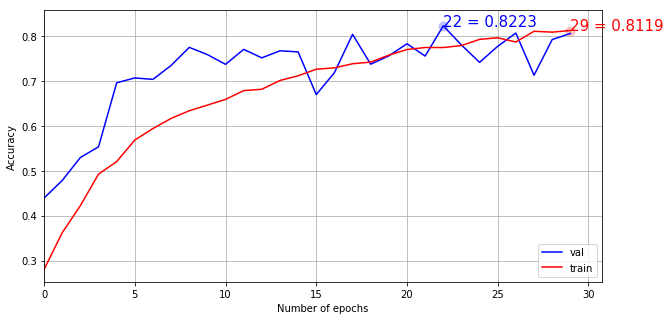

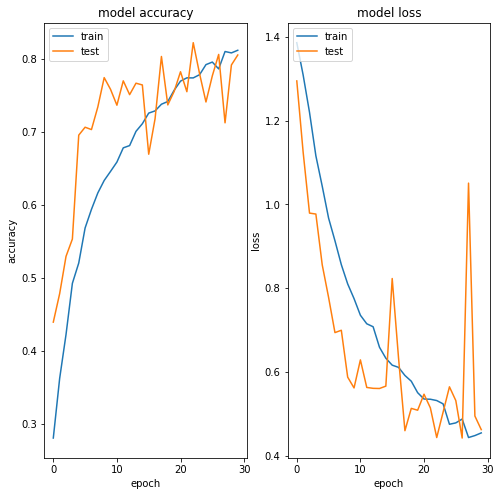

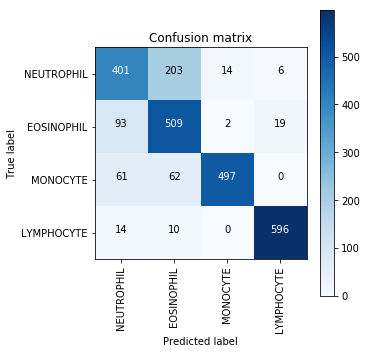

In [36]:
def runLenet5Model(x_train, y_train, x_test, y_test, epochs=30, batch_size=32, learning_rate=0.001, lr_decay=0.9, shift_fraction=0.1,
            save_dir='./result_lenet5'):
    
    num_classes = len(y_train[0])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_lenet5_model(num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    test_model(model, x_test, y_test, history)
    
runLenet5Model(X_train, y_trainHot, X_test, y_testHot)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, kernel_size=(5, 5), activation="relu", input_shape=(60, 80, 3..., kernel_initializer="he_normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(25, kernel_size=(5, 5), activation="relu", kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(180, activation="relu", kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="he_normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Dense` call 

Epoch 1/30
312/311 [==============================] - ETA: 4:02 - loss: 2.3999 - acc: 0.187 - ETA: 42s - loss: 2.4658 - acc: 0.255 - ETA: 22s - loss: 1.9646 - acc: 0.26 - ETA: 17s - loss: 1.8263 - acc: 0.26 - ETA: 16s - loss: 1.7764 - acc: 0.26 - ETA: 15s - loss: 1.7248 - acc: 0.25 - ETA: 14s - loss: 1.6946 - acc: 0.25 - ETA: 13s - loss: 1.6710 - acc: 0.26 - ETA: 13s - loss: 1.6502 - acc: 0.25 - ETA: 12s - loss: 1.6251 - acc: 0.25 - ETA: 12s - loss: 1.6107 - acc: 0.25 - ETA: 12s - loss: 1.5974 - acc: 0.25 - ETA: 12s - loss: 1.5806 - acc: 0.25 - ETA: 11s - loss: 1.5663 - acc: 0.25 - ETA: 11s - loss: 1.5576 - acc: 0.25 - ETA: 11s - loss: 1.5507 - acc: 0.25 - ETA: 10s - loss: 1.5438 - acc: 0.25 - ETA: 10s - loss: 1.5379 - acc: 0.25 - ETA: 10s - loss: 1.5328 - acc: 0.25 - ETA: 10s - loss: 1.5273 - acc: 0.25 - ETA: 10s - loss: 1.5222 - acc: 0.25 - ETA: 10s - loss: 1.5182 - acc: 0.24 - ETA: 9s - loss: 1.5140 - acc: 0.2508 - ETA: 9s - loss: 1.5103 - acc: 0.247 - ETA: 9s - loss: 1.5062 - acc: 

312/311 [==============================] - ETA: 2s - loss: 1.3883 - acc: 0.281 - ETA: 2s - loss: 1.3885 - acc: 0.232 - ETA: 2s - loss: 1.3883 - acc: 0.238 - ETA: 3s - loss: 1.3877 - acc: 0.237 - ETA: 4s - loss: 1.3878 - acc: 0.230 - ETA: 4s - loss: 1.3877 - acc: 0.235 - ETA: 5s - loss: 1.3879 - acc: 0.234 - ETA: 5s - loss: 1.3876 - acc: 0.240 - ETA: 5s - loss: 1.3877 - acc: 0.239 - ETA: 5s - loss: 1.3876 - acc: 0.240 - ETA: 6s - loss: 1.3877 - acc: 0.239 - ETA: 6s - loss: 1.3873 - acc: 0.245 - ETA: 6s - loss: 1.3873 - acc: 0.241 - ETA: 6s - loss: 1.3871 - acc: 0.245 - ETA: 6s - loss: 1.3870 - acc: 0.248 - ETA: 6s - loss: 1.3869 - acc: 0.250 - ETA: 6s - loss: 1.3868 - acc: 0.249 - ETA: 6s - loss: 1.3867 - acc: 0.250 - ETA: 6s - loss: 1.3867 - acc: 0.248 - ETA: 6s - loss: 1.3870 - acc: 0.243 - ETA: 6s - loss: 1.3872 - acc: 0.239 - ETA: 6s - loss: 1.3871 - acc: 0.237 - ETA: 6s - loss: 1.3872 - acc: 0.237 - ETA: 6s - loss: 1.3871 - acc: 0.238 - ETA: 6s - loss: 1.3869 - acc: 0.241 - ETA: 6s

312/311 [==============================] - ETA: 4s - loss: 1.3852 - acc: 0.281 - ETA: 4s - loss: 1.3884 - acc: 0.250 - ETA: 4s - loss: 1.3876 - acc: 0.250 - ETA: 5s - loss: 1.3880 - acc: 0.237 - ETA: 5s - loss: 1.3878 - acc: 0.231 - ETA: 5s - loss: 1.3876 - acc: 0.227 - ETA: 5s - loss: 1.3874 - acc: 0.228 - ETA: 5s - loss: 1.3872 - acc: 0.227 - ETA: 5s - loss: 1.3873 - acc: 0.232 - ETA: 5s - loss: 1.3875 - acc: 0.227 - ETA: 5s - loss: 1.3877 - acc: 0.229 - ETA: 6s - loss: 1.3878 - acc: 0.226 - ETA: 6s - loss: 1.3876 - acc: 0.232 - ETA: 6s - loss: 1.3871 - acc: 0.239 - ETA: 6s - loss: 1.3869 - acc: 0.239 - ETA: 6s - loss: 1.3868 - acc: 0.242 - ETA: 6s - loss: 1.3869 - acc: 0.242 - ETA: 6s - loss: 1.3867 - acc: 0.245 - ETA: 6s - loss: 1.3867 - acc: 0.242 - ETA: 6s - loss: 1.3867 - acc: 0.241 - ETA: 6s - loss: 1.3865 - acc: 0.243 - ETA: 6s - loss: 1.3866 - acc: 0.238 - ETA: 6s - loss: 1.3868 - acc: 0.239 - ETA: 6s - loss: 1.3866 - acc: 0.240 - ETA: 6s - loss: 1.3867 - acc: 0.239 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.3847 - acc: 0.312 - ETA: 9s - loss: 1.3842 - acc: 0.281 - ETA: 8s - loss: 1.3849 - acc: 0.270 - ETA: 9s - loss: 1.3847 - acc: 0.277 - ETA: 8s - loss: 1.3844 - acc: 0.284 - ETA: 7s - loss: 1.3848 - acc: 0.267 - ETA: 7s - loss: 1.3854 - acc: 0.246 - ETA: 7s - loss: 1.3852 - acc: 0.250 - ETA: 7s - loss: 1.3852 - acc: 0.248 - ETA: 6s - loss: 1.3852 - acc: 0.250 - ETA: 6s - loss: 1.3852 - acc: 0.252 - ETA: 6s - loss: 1.3852 - acc: 0.249 - ETA: 6s - loss: 1.3851 - acc: 0.249 - ETA: 6s - loss: 1.3855 - acc: 0.243 - ETA: 6s - loss: 1.3853 - acc: 0.244 - ETA: 6s - loss: 1.3856 - acc: 0.242 - ETA: 6s - loss: 1.3857 - acc: 0.243 - ETA: 7s - loss: 1.3858 - acc: 0.239 - ETA: 6s - loss: 1.3858 - acc: 0.239 - ETA: 6s - loss: 1.3861 - acc: 0.238 - ETA: 6s - loss: 1.3861 - acc: 0.239 - ETA: 7s - loss: 1.3863 - acc: 0.237 - ETA: 7s - loss: 1.3861 - acc: 0.240 - ETA: 6s - loss: 1.3861 - acc: 0.241 - ETA: 7s - loss: 1.3861 - acc: 0.240 - ETA: 7s

312/311 [==============================] - ETA: 5s - loss: 1.3829 - acc: 0.343 - ETA: 4s - loss: 1.3838 - acc: 0.281 - ETA: 6s - loss: 1.3839 - acc: 0.296 - ETA: 7s - loss: 1.3839 - acc: 0.296 - ETA: 8s - loss: 1.3849 - acc: 0.296 - ETA: 8s - loss: 1.3866 - acc: 0.276 - ETA: 7s - loss: 1.3870 - acc: 0.263 - ETA: 8s - loss: 1.3871 - acc: 0.261 - ETA: 7s - loss: 1.3870 - acc: 0.259 - ETA: 7s - loss: 1.3877 - acc: 0.252 - ETA: 7s - loss: 1.3874 - acc: 0.252 - ETA: 7s - loss: 1.3874 - acc: 0.252 - ETA: 7s - loss: 1.3870 - acc: 0.254 - ETA: 6s - loss: 1.3871 - acc: 0.249 - ETA: 7s - loss: 1.3870 - acc: 0.250 - ETA: 6s - loss: 1.3870 - acc: 0.248 - ETA: 7s - loss: 1.3868 - acc: 0.250 - ETA: 6s - loss: 1.3866 - acc: 0.255 - ETA: 6s - loss: 1.3867 - acc: 0.250 - ETA: 6s - loss: 1.3867 - acc: 0.250 - ETA: 6s - loss: 1.3867 - acc: 0.250 - ETA: 6s - loss: 1.3867 - acc: 0.250 - ETA: 6s - loss: 1.3866 - acc: 0.248 - ETA: 6s - loss: 1.3868 - acc: 0.247 - ETA: 6s - loss: 1.3868 - acc: 0.248 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 1.3938 - acc: 0.156 - ETA: 5s - loss: 1.3892 - acc: 0.226 - ETA: 7s - loss: 1.3875 - acc: 0.250 - ETA: 7s - loss: 1.3873 - acc: 0.265 - ETA: 6s - loss: 1.3860 - acc: 0.278 - ETA: 6s - loss: 1.3862 - acc: 0.266 - ETA: 6s - loss: 1.3862 - acc: 0.263 - ETA: 6s - loss: 1.3862 - acc: 0.257 - ETA: 6s - loss: 1.3861 - acc: 0.266 - ETA: 6s - loss: 1.3859 - acc: 0.272 - ETA: 6s - loss: 1.3866 - acc: 0.268 - ETA: 6s - loss: 1.3870 - acc: 0.263 - ETA: 6s - loss: 1.3868 - acc: 0.267 - ETA: 6s - loss: 1.3867 - acc: 0.262 - ETA: 6s - loss: 1.3864 - acc: 0.264 - ETA: 6s - loss: 1.3862 - acc: 0.264 - ETA: 6s - loss: 1.3865 - acc: 0.259 - ETA: 6s - loss: 1.3866 - acc: 0.257 - ETA: 6s - loss: 1.3868 - acc: 0.255 - ETA: 6s - loss: 1.3868 - acc: 0.257 - ETA: 6s - loss: 1.3868 - acc: 0.254 - ETA: 6s - loss: 1.3867 - acc: 0.257 - ETA: 6s - loss: 1.3866 - acc: 0.260 - ETA: 6s - loss: 1.3865 - acc: 0.261 - ETA: 6s - loss: 1.3866 - acc: 0.261 - ETA: 6s

312/311 [==============================] - ETA: 11s - loss: 1.3882 - acc: 0.12 - ETA: 9s - loss: 1.3879 - acc: 0.1979 - ETA: 9s - loss: 1.3872 - acc: 0.200 - ETA: 8s - loss: 1.3866 - acc: 0.232 - ETA: 9s - loss: 1.3859 - acc: 0.250 - ETA: 9s - loss: 1.3868 - acc: 0.230 - ETA: 8s - loss: 1.3863 - acc: 0.243 - ETA: 8s - loss: 1.3859 - acc: 0.253 - ETA: 8s - loss: 1.3862 - acc: 0.254 - ETA: 8s - loss: 1.3864 - acc: 0.250 - ETA: 7s - loss: 1.3865 - acc: 0.247 - ETA: 7s - loss: 1.3862 - acc: 0.250 - ETA: 7s - loss: 1.3861 - acc: 0.250 - ETA: 7s - loss: 1.3862 - acc: 0.252 - ETA: 7s - loss: 1.3863 - acc: 0.250 - ETA: 7s - loss: 1.3864 - acc: 0.247 - ETA: 7s - loss: 1.3864 - acc: 0.250 - ETA: 7s - loss: 1.3864 - acc: 0.248 - ETA: 7s - loss: 1.3864 - acc: 0.247 - ETA: 7s - loss: 1.3863 - acc: 0.250 - ETA: 7s - loss: 1.3864 - acc: 0.250 - ETA: 7s - loss: 1.3863 - acc: 0.254 - ETA: 7s - loss: 1.3862 - acc: 0.255 - ETA: 6s - loss: 1.3864 - acc: 0.252 - ETA: 7s - loss: 1.3863 - acc: 0.255 - ETA: 7

312/311 [==============================] - ETA: 8s - loss: 1.3899 - acc: 0.156 - ETA: 8s - loss: 1.3854 - acc: 0.218 - ETA: 8s - loss: 1.3860 - acc: 0.200 - ETA: 7s - loss: 1.3858 - acc: 0.208 - ETA: 6s - loss: 1.3867 - acc: 0.210 - ETA: 6s - loss: 1.3864 - acc: 0.210 - ETA: 7s - loss: 1.3869 - acc: 0.211 - ETA: 7s - loss: 1.3869 - acc: 0.218 - ETA: 7s - loss: 1.3865 - acc: 0.230 - ETA: 7s - loss: 1.3872 - acc: 0.222 - ETA: 6s - loss: 1.3874 - acc: 0.222 - ETA: 6s - loss: 1.3873 - acc: 0.229 - ETA: 6s - loss: 1.3868 - acc: 0.235 - ETA: 6s - loss: 1.3865 - acc: 0.240 - ETA: 6s - loss: 1.3865 - acc: 0.236 - ETA: 6s - loss: 1.3864 - acc: 0.239 - ETA: 6s - loss: 1.3865 - acc: 0.235 - ETA: 6s - loss: 1.3862 - acc: 0.237 - ETA: 6s - loss: 1.3861 - acc: 0.241 - ETA: 6s - loss: 1.3861 - acc: 0.240 - ETA: 7s - loss: 1.3861 - acc: 0.240 - ETA: 7s - loss: 1.3862 - acc: 0.241 - ETA: 6s - loss: 1.3858 - acc: 0.244 - ETA: 6s - loss: 1.3860 - acc: 0.244 - ETA: 6s - loss: 1.3860 - acc: 0.243 - ETA: 7s

312/311 [==============================] - ETA: 7s - loss: 1.3692 - acc: 0.250 - ETA: 7s - loss: 1.3713 - acc: 0.229 - ETA: 7s - loss: 1.3836 - acc: 0.250 - ETA: 7s - loss: 1.3807 - acc: 0.265 - ETA: 6s - loss: 1.3741 - acc: 0.278 - ETA: 7s - loss: 1.3685 - acc: 0.290 - ETA: 8s - loss: 1.3649 - acc: 0.297 - ETA: 7s - loss: 1.3631 - acc: 0.298 - ETA: 7s - loss: 1.3572 - acc: 0.309 - ETA: 7s - loss: 1.3574 - acc: 0.306 - ETA: 7s - loss: 1.3599 - acc: 0.301 - ETA: 7s - loss: 1.3622 - acc: 0.296 - ETA: 7s - loss: 1.3647 - acc: 0.297 - ETA: 6s - loss: 1.3644 - acc: 0.304 - ETA: 6s - loss: 1.3628 - acc: 0.308 - ETA: 6s - loss: 1.3613 - acc: 0.310 - ETA: 7s - loss: 1.3605 - acc: 0.311 - ETA: 6s - loss: 1.3578 - acc: 0.309 - ETA: 7s - loss: 1.3574 - acc: 0.309 - ETA: 6s - loss: 1.3554 - acc: 0.311 - ETA: 6s - loss: 1.3568 - acc: 0.311 - ETA: 7s - loss: 1.3576 - acc: 0.311 - ETA: 6s - loss: 1.3595 - acc: 0.309 - ETA: 6s - loss: 1.3599 - acc: 0.308 - ETA: 6s - loss: 1.3587 - acc: 0.309 - ETA: 7s

312/311 [==============================] - ETA: 4s - loss: 1.0398 - acc: 0.468 - ETA: 10s - loss: 1.1791 - acc: 0.42 - ETA: 7s - loss: 1.1790 - acc: 0.4562 - ETA: 8s - loss: 1.1984 - acc: 0.446 - ETA: 7s - loss: 1.1842 - acc: 0.454 - ETA: 7s - loss: 1.1820 - acc: 0.444 - ETA: 7s - loss: 1.1950 - acc: 0.427 - ETA: 7s - loss: 1.1884 - acc: 0.430 - ETA: 7s - loss: 1.1937 - acc: 0.420 - ETA: 7s - loss: 1.1778 - acc: 0.434 - ETA: 7s - loss: 1.1853 - acc: 0.431 - ETA: 7s - loss: 1.1818 - acc: 0.430 - ETA: 7s - loss: 1.1852 - acc: 0.429 - ETA: 7s - loss: 1.2082 - acc: 0.419 - ETA: 7s - loss: 1.2129 - acc: 0.418 - ETA: 7s - loss: 1.2124 - acc: 0.422 - ETA: 7s - loss: 1.2097 - acc: 0.422 - ETA: 7s - loss: 1.2135 - acc: 0.418 - ETA: 7s - loss: 1.2165 - acc: 0.420 - ETA: 7s - loss: 1.2159 - acc: 0.418 - ETA: 7s - loss: 1.2189 - acc: 0.422 - ETA: 7s - loss: 1.2140 - acc: 0.426 - ETA: 7s - loss: 1.2173 - acc: 0.416 - ETA: 7s - loss: 1.2129 - acc: 0.420 - ETA: 7s - loss: 1.2154 - acc: 0.422 - ETA: 7

312/311 [==============================] - ETA: 4s - loss: 1.2023 - acc: 0.437 - ETA: 4s - loss: 1.1552 - acc: 0.406 - ETA: 4s - loss: 1.1240 - acc: 0.437 - ETA: 3s - loss: 1.1192 - acc: 0.445 - ETA: 4s - loss: 1.1239 - acc: 0.439 - ETA: 4s - loss: 1.1142 - acc: 0.439 - ETA: 5s - loss: 1.1175 - acc: 0.441 - ETA: 5s - loss: 1.1288 - acc: 0.447 - ETA: 5s - loss: 1.1267 - acc: 0.448 - ETA: 5s - loss: 1.1331 - acc: 0.443 - ETA: 5s - loss: 1.1336 - acc: 0.446 - ETA: 6s - loss: 1.1339 - acc: 0.447 - ETA: 6s - loss: 1.1335 - acc: 0.448 - ETA: 6s - loss: 1.1249 - acc: 0.453 - ETA: 6s - loss: 1.1246 - acc: 0.456 - ETA: 6s - loss: 1.1266 - acc: 0.460 - ETA: 6s - loss: 1.1247 - acc: 0.462 - ETA: 6s - loss: 1.1237 - acc: 0.461 - ETA: 6s - loss: 1.1243 - acc: 0.457 - ETA: 6s - loss: 1.1210 - acc: 0.459 - ETA: 6s - loss: 1.1195 - acc: 0.460 - ETA: 6s - loss: 1.1207 - acc: 0.454 - ETA: 6s - loss: 1.1219 - acc: 0.455 - ETA: 6s - loss: 1.1220 - acc: 0.456 - ETA: 6s - loss: 1.1236 - acc: 0.458 - ETA: 6s

312/311 [==============================] - ETA: 4s - loss: 1.1372 - acc: 0.406 - ETA: 5s - loss: 1.0601 - acc: 0.437 - ETA: 5s - loss: 1.0429 - acc: 0.457 - ETA: 5s - loss: 1.1050 - acc: 0.437 - ETA: 5s - loss: 1.1284 - acc: 0.435 - ETA: 5s - loss: 1.1218 - acc: 0.435 - ETA: 5s - loss: 1.1306 - acc: 0.427 - ETA: 5s - loss: 1.1314 - acc: 0.429 - ETA: 5s - loss: 1.1284 - acc: 0.435 - ETA: 5s - loss: 1.1247 - acc: 0.435 - ETA: 5s - loss: 1.1209 - acc: 0.440 - ETA: 6s - loss: 1.1163 - acc: 0.442 - ETA: 6s - loss: 1.1130 - acc: 0.445 - ETA: 6s - loss: 1.1087 - acc: 0.449 - ETA: 6s - loss: 1.1085 - acc: 0.454 - ETA: 6s - loss: 1.1028 - acc: 0.460 - ETA: 6s - loss: 1.1014 - acc: 0.464 - ETA: 6s - loss: 1.0955 - acc: 0.469 - ETA: 6s - loss: 1.0929 - acc: 0.469 - ETA: 6s - loss: 1.0963 - acc: 0.468 - ETA: 6s - loss: 1.0982 - acc: 0.468 - ETA: 6s - loss: 1.0997 - acc: 0.473 - ETA: 6s - loss: 1.1017 - acc: 0.469 - ETA: 6s - loss: 1.0967 - acc: 0.472 - ETA: 6s - loss: 1.0969 - acc: 0.472 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.9955 - acc: 0.468 - ETA: 4s - loss: 1.0436 - acc: 0.520 - ETA: 4s - loss: 0.9965 - acc: 0.541 - ETA: 5s - loss: 1.0131 - acc: 0.528 - ETA: 4s - loss: 1.0433 - acc: 0.522 - ETA: 4s - loss: 1.0417 - acc: 0.509 - ETA: 5s - loss: 1.0441 - acc: 0.513 - ETA: 5s - loss: 1.0410 - acc: 0.507 - ETA: 5s - loss: 1.0356 - acc: 0.512 - ETA: 5s - loss: 1.0332 - acc: 0.511 - ETA: 6s - loss: 1.0429 - acc: 0.510 - ETA: 6s - loss: 1.0526 - acc: 0.508 - ETA: 6s - loss: 1.0466 - acc: 0.515 - ETA: 6s - loss: 1.0440 - acc: 0.518 - ETA: 6s - loss: 1.0350 - acc: 0.521 - ETA: 6s - loss: 1.0267 - acc: 0.529 - ETA: 6s - loss: 1.0211 - acc: 0.529 - ETA: 6s - loss: 1.0208 - acc: 0.529 - ETA: 6s - loss: 1.0220 - acc: 0.529 - ETA: 6s - loss: 1.0197 - acc: 0.525 - ETA: 6s - loss: 1.0344 - acc: 0.520 - ETA: 6s - loss: 1.0344 - acc: 0.521 - ETA: 6s - loss: 1.0373 - acc: 0.519 - ETA: 6s - loss: 1.0348 - acc: 0.520 - ETA: 6s - loss: 1.0330 - acc: 0.522 - ETA: 6s

312/311 [==============================] - ETA: 3s - loss: 0.8620 - acc: 0.625 - ETA: 2s - loss: 0.9554 - acc: 0.584 - ETA: 2s - loss: 0.9405 - acc: 0.598 - ETA: 3s - loss: 0.9487 - acc: 0.591 - ETA: 4s - loss: 0.9428 - acc: 0.581 - ETA: 4s - loss: 0.9604 - acc: 0.565 - ETA: 4s - loss: 0.9604 - acc: 0.566 - ETA: 5s - loss: 0.9638 - acc: 0.559 - ETA: 5s - loss: 0.9571 - acc: 0.558 - ETA: 5s - loss: 0.9623 - acc: 0.564 - ETA: 5s - loss: 0.9674 - acc: 0.556 - ETA: 6s - loss: 0.9682 - acc: 0.556 - ETA: 6s - loss: 0.9700 - acc: 0.557 - ETA: 6s - loss: 0.9700 - acc: 0.555 - ETA: 6s - loss: 0.9808 - acc: 0.551 - ETA: 6s - loss: 0.9789 - acc: 0.548 - ETA: 6s - loss: 0.9812 - acc: 0.546 - ETA: 6s - loss: 0.9834 - acc: 0.546 - ETA: 6s - loss: 0.9876 - acc: 0.545 - ETA: 6s - loss: 0.9828 - acc: 0.547 - ETA: 6s - loss: 0.9846 - acc: 0.543 - ETA: 6s - loss: 0.9844 - acc: 0.543 - ETA: 6s - loss: 0.9809 - acc: 0.543 - ETA: 6s - loss: 0.9785 - acc: 0.545 - ETA: 6s - loss: 0.9775 - acc: 0.548 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 1.0108 - acc: 0.500 - ETA: 2s - loss: 0.9068 - acc: 0.575 - ETA: 2s - loss: 0.9171 - acc: 0.588 - ETA: 3s - loss: 0.9316 - acc: 0.584 - ETA: 3s - loss: 0.9335 - acc: 0.588 - ETA: 4s - loss: 0.9228 - acc: 0.596 - ETA: 4s - loss: 0.9190 - acc: 0.593 - ETA: 5s - loss: 0.8991 - acc: 0.604 - ETA: 5s - loss: 0.8999 - acc: 0.599 - ETA: 5s - loss: 0.8904 - acc: 0.601 - ETA: 5s - loss: 0.8899 - acc: 0.600 - ETA: 5s - loss: 0.8922 - acc: 0.600 - ETA: 6s - loss: 0.8896 - acc: 0.602 - ETA: 6s - loss: 0.8924 - acc: 0.601 - ETA: 6s - loss: 0.8918 - acc: 0.601 - ETA: 6s - loss: 0.8830 - acc: 0.603 - ETA: 6s - loss: 0.8956 - acc: 0.601 - ETA: 6s - loss: 0.9051 - acc: 0.597 - ETA: 6s - loss: 0.9105 - acc: 0.593 - ETA: 6s - loss: 0.9114 - acc: 0.592 - ETA: 6s - loss: 0.9134 - acc: 0.590 - ETA: 6s - loss: 0.9069 - acc: 0.594 - ETA: 6s - loss: 0.8988 - acc: 0.598 - ETA: 6s - loss: 0.8988 - acc: 0.597 - ETA: 6s - loss: 0.8924 - acc: 0.599 - ETA: 6s

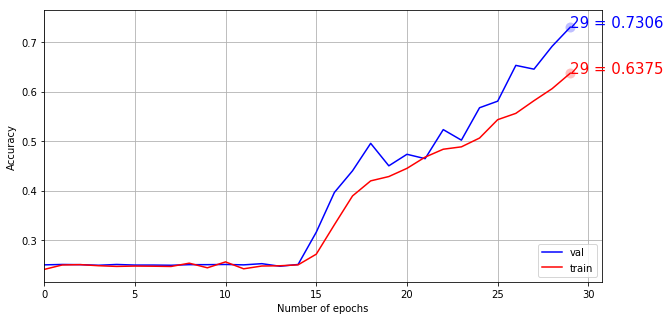

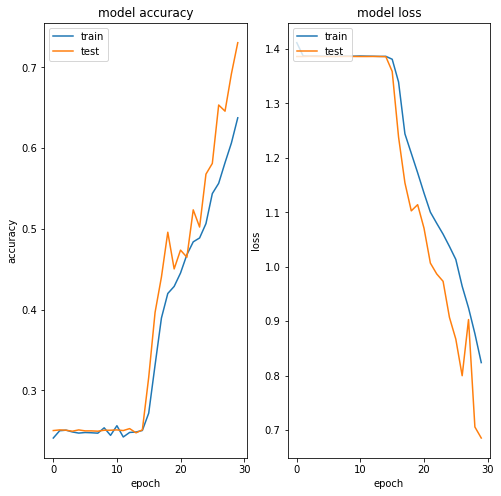

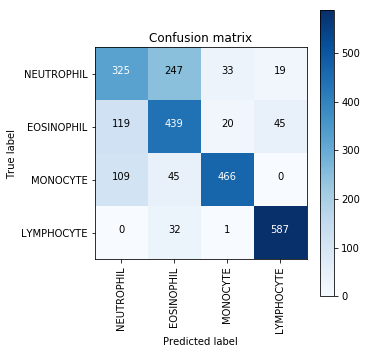

In [37]:
def runLenet5Model2(x_train, y_train, x_test, y_test, epochs=30, batch_size=32, learning_rate=0.001, lr_decay=0.9, shift_fraction=0.1,
            save_dir='./result_lenet5_2'):
    
    num_classes = len(y_train[0])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_lenet5_model(num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    test_model(model, x_test, y_test, history)
    
runLenet5Model2(X_train_2, y_trainHot_2, X_test_2, y_testHot_2)

Epoch 1/30
312/311 [==============================] - ETA: 2:55 - loss: 1.4929 - acc: 0.312 - ETA: 48s - loss: 1.6471 - acc: 0.328 - ETA: 30s - loss: 1.6741 - acc: 0.31 - ETA: 22s - loss: 1.6239 - acc: 0.30 - ETA: 20s - loss: 1.5982 - acc: 0.32 - ETA: 18s - loss: 1.5759 - acc: 0.32 - ETA: 16s - loss: 1.5474 - acc: 0.34 - ETA: 14s - loss: 1.5145 - acc: 0.34 - ETA: 13s - loss: 1.4817 - acc: 0.35 - ETA: 12s - loss: 1.4721 - acc: 0.36 - ETA: 12s - loss: 1.4581 - acc: 0.36 - ETA: 12s - loss: 1.4465 - acc: 0.37 - ETA: 12s - loss: 1.4365 - acc: 0.37 - ETA: 11s - loss: 1.4293 - acc: 0.37 - ETA: 11s - loss: 1.4155 - acc: 0.38 - ETA: 11s - loss: 1.4079 - acc: 0.38 - ETA: 10s - loss: 1.4010 - acc: 0.38 - ETA: 10s - loss: 1.3852 - acc: 0.39 - ETA: 10s - loss: 1.3774 - acc: 0.40 - ETA: 9s - loss: 1.3713 - acc: 0.4069 - ETA: 9s - loss: 1.3682 - acc: 0.408 - ETA: 9s - loss: 1.3585 - acc: 0.413 - ETA: 9s - loss: 1.3522 - acc: 0.415 - ETA: 9s - loss: 1.3479 - acc: 0.415 - ETA: 9s - loss: 1.3451 - acc: 

312/311 [==============================] - ETA: 9s - loss: 0.9289 - acc: 0.625 - ETA: 7s - loss: 0.8737 - acc: 0.687 - ETA: 6s - loss: 0.8593 - acc: 0.683 - ETA: 6s - loss: 0.8107 - acc: 0.693 - ETA: 6s - loss: 0.8147 - acc: 0.687 - ETA: 6s - loss: 0.8095 - acc: 0.689 - ETA: 6s - loss: 0.8296 - acc: 0.678 - ETA: 6s - loss: 0.8444 - acc: 0.664 - ETA: 6s - loss: 0.8501 - acc: 0.659 - ETA: 6s - loss: 0.8592 - acc: 0.654 - ETA: 6s - loss: 0.8564 - acc: 0.656 - ETA: 6s - loss: 0.8544 - acc: 0.658 - ETA: 7s - loss: 0.8561 - acc: 0.654 - ETA: 6s - loss: 0.8555 - acc: 0.654 - ETA: 6s - loss: 0.8502 - acc: 0.660 - ETA: 6s - loss: 0.8634 - acc: 0.652 - ETA: 7s - loss: 0.8600 - acc: 0.653 - ETA: 7s - loss: 0.8612 - acc: 0.652 - ETA: 7s - loss: 0.8537 - acc: 0.657 - ETA: 7s - loss: 0.8540 - acc: 0.654 - ETA: 6s - loss: 0.8480 - acc: 0.656 - ETA: 6s - loss: 0.8491 - acc: 0.653 - ETA: 6s - loss: 0.8528 - acc: 0.652 - ETA: 6s - loss: 0.8486 - acc: 0.654 - ETA: 7s - loss: 0.8539 - acc: 0.654 - ETA: 7s

312/311 [==============================] - ETA: 5s - loss: 0.5817 - acc: 0.750 - ETA: 8s - loss: 0.7646 - acc: 0.687 - ETA: 6s - loss: 0.8010 - acc: 0.666 - ETA: 7s - loss: 0.7821 - acc: 0.677 - ETA: 7s - loss: 0.8012 - acc: 0.670 - ETA: 6s - loss: 0.7996 - acc: 0.678 - ETA: 6s - loss: 0.8003 - acc: 0.678 - ETA: 6s - loss: 0.7926 - acc: 0.670 - ETA: 6s - loss: 0.7847 - acc: 0.679 - ETA: 6s - loss: 0.7954 - acc: 0.675 - ETA: 6s - loss: 0.7949 - acc: 0.674 - ETA: 6s - loss: 0.8001 - acc: 0.673 - ETA: 6s - loss: 0.7907 - acc: 0.677 - ETA: 6s - loss: 0.7977 - acc: 0.669 - ETA: 6s - loss: 0.8009 - acc: 0.670 - ETA: 6s - loss: 0.8019 - acc: 0.667 - ETA: 6s - loss: 0.7974 - acc: 0.670 - ETA: 6s - loss: 0.7930 - acc: 0.675 - ETA: 6s - loss: 0.7939 - acc: 0.677 - ETA: 6s - loss: 0.7842 - acc: 0.682 - ETA: 6s - loss: 0.7858 - acc: 0.680 - ETA: 6s - loss: 0.7903 - acc: 0.677 - ETA: 6s - loss: 0.7854 - acc: 0.679 - ETA: 6s - loss: 0.7868 - acc: 0.679 - ETA: 6s - loss: 0.7809 - acc: 0.681 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.7380 - acc: 0.718 - ETA: 6s - loss: 0.6622 - acc: 0.757 - ETA: 6s - loss: 0.6747 - acc: 0.736 - ETA: 6s - loss: 0.6651 - acc: 0.737 - ETA: 6s - loss: 0.6631 - acc: 0.726 - ETA: 6s - loss: 0.6472 - acc: 0.738 - ETA: 5s - loss: 0.6480 - acc: 0.738 - ETA: 5s - loss: 0.6412 - acc: 0.738 - ETA: 5s - loss: 0.6490 - acc: 0.732 - ETA: 5s - loss: 0.6632 - acc: 0.722 - ETA: 6s - loss: 0.6713 - acc: 0.715 - ETA: 6s - loss: 0.6793 - acc: 0.709 - ETA: 6s - loss: 0.6883 - acc: 0.704 - ETA: 6s - loss: 0.6823 - acc: 0.709 - ETA: 6s - loss: 0.6830 - acc: 0.709 - ETA: 6s - loss: 0.6836 - acc: 0.706 - ETA: 6s - loss: 0.6860 - acc: 0.703 - ETA: 6s - loss: 0.6872 - acc: 0.702 - ETA: 6s - loss: 0.6910 - acc: 0.701 - ETA: 6s - loss: 0.6878 - acc: 0.702 - ETA: 6s - loss: 0.6874 - acc: 0.701 - ETA: 6s - loss: 0.6824 - acc: 0.703 - ETA: 6s - loss: 0.6878 - acc: 0.700 - ETA: 6s - loss: 0.6882 - acc: 0.702 - ETA: 6s - loss: 0.6886 - acc: 0.702 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.7405 - acc: 0.687 - ETA: 6s - loss: 0.5834 - acc: 0.781 - ETA: 6s - loss: 0.5366 - acc: 0.794 - ETA: 6s - loss: 0.5771 - acc: 0.768 - ETA: 6s - loss: 0.5946 - acc: 0.766 - ETA: 6s - loss: 0.6013 - acc: 0.763 - ETA: 6s - loss: 0.5858 - acc: 0.769 - ETA: 5s - loss: 0.5896 - acc: 0.769 - ETA: 5s - loss: 0.5935 - acc: 0.763 - ETA: 6s - loss: 0.5973 - acc: 0.762 - ETA: 6s - loss: 0.6172 - acc: 0.751 - ETA: 6s - loss: 0.6154 - acc: 0.752 - ETA: 6s - loss: 0.6027 - acc: 0.757 - ETA: 6s - loss: 0.6031 - acc: 0.757 - ETA: 6s - loss: 0.5987 - acc: 0.760 - ETA: 6s - loss: 0.6008 - acc: 0.757 - ETA: 6s - loss: 0.6097 - acc: 0.755 - ETA: 6s - loss: 0.6161 - acc: 0.752 - ETA: 6s - loss: 0.6120 - acc: 0.752 - ETA: 6s - loss: 0.6138 - acc: 0.754 - ETA: 6s - loss: 0.6154 - acc: 0.751 - ETA: 6s - loss: 0.6155 - acc: 0.750 - ETA: 6s - loss: 0.6188 - acc: 0.747 - ETA: 6s - loss: 0.6162 - acc: 0.747 - ETA: 6s - loss: 0.6154 - acc: 0.747 - ETA: 6s

312/311 [==============================] - ETA: 2s - loss: 0.8637 - acc: 0.600 - ETA: 5s - loss: 0.6715 - acc: 0.689 - ETA: 5s - loss: 0.6683 - acc: 0.692 - ETA: 5s - loss: 0.6947 - acc: 0.700 - ETA: 5s - loss: 0.6626 - acc: 0.719 - ETA: 5s - loss: 0.6304 - acc: 0.740 - ETA: 5s - loss: 0.6110 - acc: 0.738 - ETA: 5s - loss: 0.5971 - acc: 0.751 - ETA: 5s - loss: 0.5943 - acc: 0.756 - ETA: 5s - loss: 0.5990 - acc: 0.751 - ETA: 6s - loss: 0.5950 - acc: 0.754 - ETA: 6s - loss: 0.5954 - acc: 0.753 - ETA: 6s - loss: 0.5904 - acc: 0.752 - ETA: 6s - loss: 0.5806 - acc: 0.758 - ETA: 6s - loss: 0.5770 - acc: 0.762 - ETA: 6s - loss: 0.5962 - acc: 0.756 - ETA: 6s - loss: 0.5968 - acc: 0.754 - ETA: 6s - loss: 0.5989 - acc: 0.752 - ETA: 6s - loss: 0.5967 - acc: 0.755 - ETA: 6s - loss: 0.5977 - acc: 0.752 - ETA: 6s - loss: 0.6000 - acc: 0.750 - ETA: 6s - loss: 0.6078 - acc: 0.747 - ETA: 6s - loss: 0.5981 - acc: 0.750 - ETA: 6s - loss: 0.5967 - acc: 0.751 - ETA: 6s - loss: 0.6013 - acc: 0.750 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.5471 - acc: 0.750 - ETA: 6s - loss: 0.4932 - acc: 0.820 - ETA: 6s - loss: 0.6105 - acc: 0.763 - ETA: 6s - loss: 0.5757 - acc: 0.765 - ETA: 6s - loss: 0.5694 - acc: 0.764 - ETA: 5s - loss: 0.5636 - acc: 0.763 - ETA: 5s - loss: 0.5682 - acc: 0.761 - ETA: 5s - loss: 0.5664 - acc: 0.762 - ETA: 5s - loss: 0.5590 - acc: 0.766 - ETA: 6s - loss: 0.5590 - acc: 0.764 - ETA: 6s - loss: 0.5570 - acc: 0.766 - ETA: 6s - loss: 0.5501 - acc: 0.770 - ETA: 6s - loss: 0.5578 - acc: 0.762 - ETA: 6s - loss: 0.5556 - acc: 0.763 - ETA: 6s - loss: 0.5597 - acc: 0.762 - ETA: 6s - loss: 0.5625 - acc: 0.757 - ETA: 6s - loss: 0.5602 - acc: 0.758 - ETA: 6s - loss: 0.5658 - acc: 0.757 - ETA: 6s - loss: 0.5687 - acc: 0.752 - ETA: 6s - loss: 0.5685 - acc: 0.753 - ETA: 6s - loss: 0.5613 - acc: 0.756 - ETA: 6s - loss: 0.5601 - acc: 0.756 - ETA: 6s - loss: 0.5619 - acc: 0.759 - ETA: 6s - loss: 0.5564 - acc: 0.762 - ETA: 6s - loss: 0.5587 - acc: 0.762 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.4913 - acc: 0.812 - ETA: 6s - loss: 0.4474 - acc: 0.820 - ETA: 6s - loss: 0.4457 - acc: 0.838 - ETA: 6s - loss: 0.4945 - acc: 0.812 - ETA: 6s - loss: 0.4959 - acc: 0.804 - ETA: 6s - loss: 0.5086 - acc: 0.797 - ETA: 6s - loss: 0.5189 - acc: 0.796 - ETA: 6s - loss: 0.5369 - acc: 0.785 - ETA: 6s - loss: 0.5257 - acc: 0.790 - ETA: 5s - loss: 0.5508 - acc: 0.780 - ETA: 5s - loss: 0.5454 - acc: 0.778 - ETA: 6s - loss: 0.5476 - acc: 0.776 - ETA: 6s - loss: 0.5367 - acc: 0.784 - ETA: 6s - loss: 0.5261 - acc: 0.788 - ETA: 6s - loss: 0.5278 - acc: 0.788 - ETA: 6s - loss: 0.5313 - acc: 0.784 - ETA: 6s - loss: 0.5362 - acc: 0.784 - ETA: 6s - loss: 0.5330 - acc: 0.786 - ETA: 6s - loss: 0.5345 - acc: 0.786 - ETA: 6s - loss: 0.5346 - acc: 0.789 - ETA: 6s - loss: 0.5355 - acc: 0.789 - ETA: 6s - loss: 0.5371 - acc: 0.789 - ETA: 6s - loss: 0.5422 - acc: 0.788 - ETA: 6s - loss: 0.5392 - acc: 0.787 - ETA: 6s - loss: 0.5359 - acc: 0.790 - ETA: 6s

312/311 [==============================] - ETA: 7s - loss: 0.5709 - acc: 0.718 - ETA: 6s - loss: 0.5953 - acc: 0.750 - ETA: 6s - loss: 0.5808 - acc: 0.772 - ETA: 5s - loss: 0.5434 - acc: 0.793 - ETA: 5s - loss: 0.5176 - acc: 0.790 - ETA: 5s - loss: 0.5074 - acc: 0.787 - ETA: 5s - loss: 0.5077 - acc: 0.792 - ETA: 5s - loss: 0.5143 - acc: 0.789 - ETA: 5s - loss: 0.5052 - acc: 0.791 - ETA: 5s - loss: 0.4945 - acc: 0.796 - ETA: 6s - loss: 0.4889 - acc: 0.799 - ETA: 6s - loss: 0.4890 - acc: 0.797 - ETA: 6s - loss: 0.4957 - acc: 0.791 - ETA: 6s - loss: 0.4948 - acc: 0.793 - ETA: 6s - loss: 0.4876 - acc: 0.797 - ETA: 6s - loss: 0.4938 - acc: 0.798 - ETA: 6s - loss: 0.4900 - acc: 0.799 - ETA: 6s - loss: 0.4883 - acc: 0.800 - ETA: 6s - loss: 0.4884 - acc: 0.801 - ETA: 6s - loss: 0.4890 - acc: 0.800 - ETA: 6s - loss: 0.4911 - acc: 0.798 - ETA: 6s - loss: 0.4895 - acc: 0.801 - ETA: 6s - loss: 0.4886 - acc: 0.800 - ETA: 6s - loss: 0.4935 - acc: 0.798 - ETA: 6s - loss: 0.4985 - acc: 0.795 - ETA: 6s

312/311 [==============================] - ETA: 7s - loss: 0.3290 - acc: 0.875 - ETA: 6s - loss: 0.4329 - acc: 0.812 - ETA: 6s - loss: 0.4816 - acc: 0.790 - ETA: 6s - loss: 0.4904 - acc: 0.784 - ETA: 6s - loss: 0.4881 - acc: 0.795 - ETA: 5s - loss: 0.4919 - acc: 0.794 - ETA: 5s - loss: 0.4834 - acc: 0.801 - ETA: 5s - loss: 0.4829 - acc: 0.805 - ETA: 5s - loss: 0.4926 - acc: 0.808 - ETA: 6s - loss: 0.4959 - acc: 0.806 - ETA: 6s - loss: 0.5016 - acc: 0.803 - ETA: 6s - loss: 0.4961 - acc: 0.807 - ETA: 6s - loss: 0.4885 - acc: 0.813 - ETA: 6s - loss: 0.4873 - acc: 0.816 - ETA: 6s - loss: 0.4993 - acc: 0.809 - ETA: 6s - loss: 0.5009 - acc: 0.806 - ETA: 6s - loss: 0.5077 - acc: 0.802 - ETA: 6s - loss: 0.5102 - acc: 0.801 - ETA: 6s - loss: 0.5172 - acc: 0.799 - ETA: 6s - loss: 0.5156 - acc: 0.801 - ETA: 6s - loss: 0.5156 - acc: 0.800 - ETA: 6s - loss: 0.5151 - acc: 0.799 - ETA: 6s - loss: 0.5182 - acc: 0.796 - ETA: 6s - loss: 0.5114 - acc: 0.799 - ETA: 6s - loss: 0.5128 - acc: 0.796 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.6526 - acc: 0.718 - ETA: 6s - loss: 0.4975 - acc: 0.773 - ETA: 6s - loss: 0.5027 - acc: 0.772 - ETA: 6s - loss: 0.4741 - acc: 0.800 - ETA: 6s - loss: 0.4887 - acc: 0.798 - ETA: 6s - loss: 0.4818 - acc: 0.796 - ETA: 6s - loss: 0.4968 - acc: 0.791 - ETA: 6s - loss: 0.4976 - acc: 0.790 - ETA: 6s - loss: 0.4831 - acc: 0.798 - ETA: 6s - loss: 0.4880 - acc: 0.797 - ETA: 6s - loss: 0.4792 - acc: 0.799 - ETA: 6s - loss: 0.4643 - acc: 0.810 - ETA: 6s - loss: 0.4690 - acc: 0.806 - ETA: 6s - loss: 0.4724 - acc: 0.804 - ETA: 6s - loss: 0.4718 - acc: 0.808 - ETA: 6s - loss: 0.4781 - acc: 0.799 - ETA: 6s - loss: 0.4794 - acc: 0.800 - ETA: 6s - loss: 0.4684 - acc: 0.807 - ETA: 6s - loss: 0.4600 - acc: 0.810 - ETA: 6s - loss: 0.4588 - acc: 0.812 - ETA: 6s - loss: 0.4593 - acc: 0.812 - ETA: 6s - loss: 0.4577 - acc: 0.815 - ETA: 6s - loss: 0.4556 - acc: 0.813 - ETA: 6s - loss: 0.4566 - acc: 0.813 - ETA: 6s - loss: 0.4543 - acc: 0.813 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.5347 - acc: 0.812 - ETA: 6s - loss: 0.4415 - acc: 0.835 - ETA: 6s - loss: 0.4472 - acc: 0.843 - ETA: 6s - loss: 0.4340 - acc: 0.846 - ETA: 6s - loss: 0.4520 - acc: 0.834 - ETA: 5s - loss: 0.4440 - acc: 0.839 - ETA: 5s - loss: 0.4424 - acc: 0.842 - ETA: 5s - loss: 0.4156 - acc: 0.849 - ETA: 5s - loss: 0.4129 - acc: 0.848 - ETA: 5s - loss: 0.4232 - acc: 0.843 - ETA: 5s - loss: 0.4289 - acc: 0.845 - ETA: 6s - loss: 0.4335 - acc: 0.843 - ETA: 6s - loss: 0.4373 - acc: 0.841 - ETA: 6s - loss: 0.4460 - acc: 0.837 - ETA: 6s - loss: 0.4464 - acc: 0.838 - ETA: 6s - loss: 0.4541 - acc: 0.833 - ETA: 6s - loss: 0.4546 - acc: 0.833 - ETA: 6s - loss: 0.4584 - acc: 0.832 - ETA: 6s - loss: 0.4612 - acc: 0.828 - ETA: 6s - loss: 0.4656 - acc: 0.824 - ETA: 6s - loss: 0.4679 - acc: 0.823 - ETA: 6s - loss: 0.4705 - acc: 0.822 - ETA: 6s - loss: 0.4620 - acc: 0.826 - ETA: 6s - loss: 0.4645 - acc: 0.827 - ETA: 6s - loss: 0.4632 - acc: 0.826 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.4571 - acc: 0.781 - ETA: 6s - loss: 0.3841 - acc: 0.835 - ETA: 6s - loss: 0.3579 - acc: 0.852 - ETA: 6s - loss: 0.4051 - acc: 0.809 - ETA: 6s - loss: 0.4278 - acc: 0.805 - ETA: 6s - loss: 0.4323 - acc: 0.798 - ETA: 5s - loss: 0.4578 - acc: 0.787 - ETA: 5s - loss: 0.4518 - acc: 0.791 - ETA: 5s - loss: 0.4309 - acc: 0.800 - ETA: 5s - loss: 0.4288 - acc: 0.808 - ETA: 6s - loss: 0.4264 - acc: 0.807 - ETA: 6s - loss: 0.4208 - acc: 0.811 - ETA: 6s - loss: 0.4352 - acc: 0.807 - ETA: 6s - loss: 0.4265 - acc: 0.812 - ETA: 6s - loss: 0.4259 - acc: 0.814 - ETA: 6s - loss: 0.4356 - acc: 0.810 - ETA: 6s - loss: 0.4396 - acc: 0.811 - ETA: 6s - loss: 0.4357 - acc: 0.813 - ETA: 6s - loss: 0.4470 - acc: 0.809 - ETA: 6s - loss: 0.4476 - acc: 0.810 - ETA: 6s - loss: 0.4444 - acc: 0.811 - ETA: 6s - loss: 0.4420 - acc: 0.813 - ETA: 6s - loss: 0.4458 - acc: 0.812 - ETA: 6s - loss: 0.4464 - acc: 0.812 - ETA: 6s - loss: 0.4508 - acc: 0.812 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.5154 - acc: 0.781 - ETA: 6s - loss: 0.3676 - acc: 0.851 - ETA: 6s - loss: 0.4438 - acc: 0.812 - ETA: 6s - loss: 0.4927 - acc: 0.809 - ETA: 6s - loss: 0.4564 - acc: 0.819 - ETA: 6s - loss: 0.4313 - acc: 0.834 - ETA: 6s - loss: 0.4301 - acc: 0.830 - ETA: 6s - loss: 0.4431 - acc: 0.832 - ETA: 6s - loss: 0.4374 - acc: 0.840 - ETA: 6s - loss: 0.4388 - acc: 0.837 - ETA: 6s - loss: 0.4398 - acc: 0.836 - ETA: 6s - loss: 0.4443 - acc: 0.830 - ETA: 6s - loss: 0.4408 - acc: 0.829 - ETA: 6s - loss: 0.4426 - acc: 0.826 - ETA: 6s - loss: 0.4412 - acc: 0.824 - ETA: 6s - loss: 0.4345 - acc: 0.828 - ETA: 6s - loss: 0.4333 - acc: 0.827 - ETA: 6s - loss: 0.4281 - acc: 0.828 - ETA: 6s - loss: 0.4312 - acc: 0.825 - ETA: 6s - loss: 0.4331 - acc: 0.825 - ETA: 6s - loss: 0.4278 - acc: 0.827 - ETA: 6s - loss: 0.4337 - acc: 0.824 - ETA: 6s - loss: 0.4348 - acc: 0.824 - ETA: 6s - loss: 0.4348 - acc: 0.824 - ETA: 6s - loss: 0.4336 - acc: 0.825 - ETA: 6s

312/311 [==============================] - ETA: 7s - loss: 0.6416 - acc: 0.750 - ETA: 6s - loss: 0.4378 - acc: 0.796 - ETA: 6s - loss: 0.3666 - acc: 0.839 - ETA: 6s - loss: 0.3900 - acc: 0.831 - ETA: 6s - loss: 0.4246 - acc: 0.819 - ETA: 5s - loss: 0.4161 - acc: 0.824 - ETA: 5s - loss: 0.4161 - acc: 0.828 - ETA: 5s - loss: 0.4153 - acc: 0.832 - ETA: 5s - loss: 0.4148 - acc: 0.830 - ETA: 5s - loss: 0.4064 - acc: 0.833 - ETA: 6s - loss: 0.4126 - acc: 0.833 - ETA: 6s - loss: 0.4162 - acc: 0.829 - ETA: 6s - loss: 0.4146 - acc: 0.832 - ETA: 6s - loss: 0.4157 - acc: 0.831 - ETA: 6s - loss: 0.4119 - acc: 0.832 - ETA: 6s - loss: 0.4157 - acc: 0.829 - ETA: 6s - loss: 0.4189 - acc: 0.829 - ETA: 6s - loss: 0.4161 - acc: 0.830 - ETA: 6s - loss: 0.4071 - acc: 0.837 - ETA: 6s - loss: 0.4133 - acc: 0.834 - ETA: 6s - loss: 0.4167 - acc: 0.834 - ETA: 6s - loss: 0.4188 - acc: 0.831 - ETA: 6s - loss: 0.4192 - acc: 0.830 - ETA: 6s - loss: 0.4179 - acc: 0.830 - ETA: 6s - loss: 0.4208 - acc: 0.829 - ETA: 6s

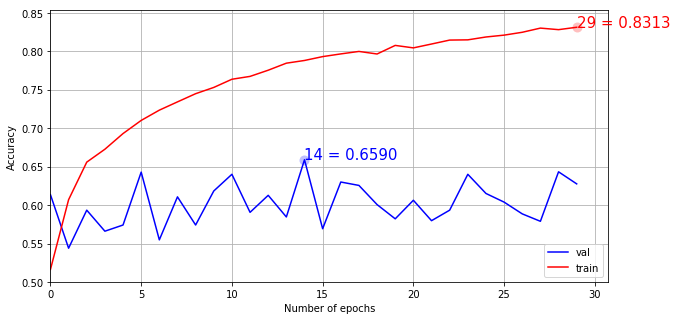

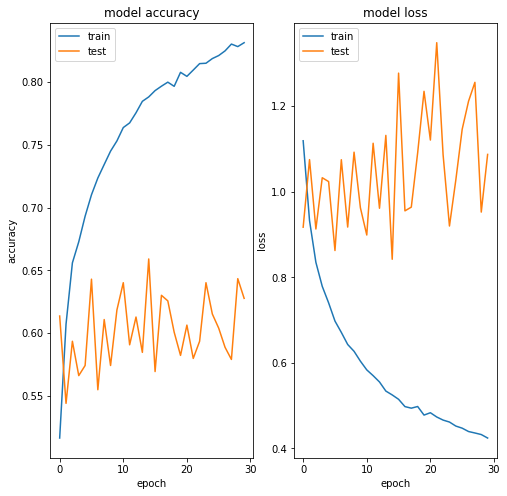

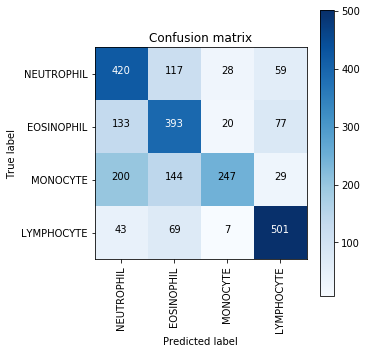

In [38]:
def runVgg16(x_train, y_train, x_test, y_test, epochs=30, batch_size=32, learning_rate=0.001, lr_decay=0.9, shift_fraction=0.1,
            save_dir='./result_vgg16'):
    
    num_classes = len(y_train[0])
    model_name = 'vgg16'
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_keras_model(model_name, num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    test_model(model, x_test, y_test, history)
    
runVgg16(X_train, y_trainHot, X_test, y_testHot)

Epoch 1/30
312/311 [==============================] - ETA: 2:51 - loss: 1.4230 - acc: 0.312 - ETA: 47s - loss: 1.7679 - acc: 0.281 - ETA: 29s - loss: 1.6953 - acc: 0.29 - ETA: 22s - loss: 1.6526 - acc: 0.31 - ETA: 18s - loss: 1.6371 - acc: 0.29 - ETA: 16s - loss: 1.6108 - acc: 0.29 - ETA: 14s - loss: 1.5941 - acc: 0.29 - ETA: 13s - loss: 1.5786 - acc: 0.29 - ETA: 12s - loss: 1.5507 - acc: 0.30 - ETA: 11s - loss: 1.5447 - acc: 0.30 - ETA: 11s - loss: 1.5243 - acc: 0.31 - ETA: 10s - loss: 1.5140 - acc: 0.31 - ETA: 10s - loss: 1.5050 - acc: 0.31 - ETA: 10s - loss: 1.5049 - acc: 0.31 - ETA: 10s - loss: 1.4910 - acc: 0.31 - ETA: 10s - loss: 1.4875 - acc: 0.31 - ETA: 10s - loss: 1.4764 - acc: 0.32 - ETA: 9s - loss: 1.4649 - acc: 0.3267 - ETA: 9s - loss: 1.4592 - acc: 0.326 - ETA: 9s - loss: 1.4506 - acc: 0.330 - ETA: 9s - loss: 1.4448 - acc: 0.328 - ETA: 9s - loss: 1.4425 - acc: 0.331 - ETA: 9s - loss: 1.4390 - acc: 0.332 - ETA: 9s - loss: 1.4309 - acc: 0.334 - ETA: 9s - loss: 1.4242 - acc: 

312/311 [==============================] - ETA: 9s - loss: 1.2582 - acc: 0.406 - ETA: 9s - loss: 1.0401 - acc: 0.552 - ETA: 7s - loss: 1.0002 - acc: 0.567 - ETA: 7s - loss: 1.0132 - acc: 0.541 - ETA: 7s - loss: 0.9925 - acc: 0.565 - ETA: 7s - loss: 0.9998 - acc: 0.560 - ETA: 8s - loss: 0.9861 - acc: 0.577 - ETA: 8s - loss: 0.9900 - acc: 0.574 - ETA: 7s - loss: 1.0094 - acc: 0.563 - ETA: 7s - loss: 1.0101 - acc: 0.561 - ETA: 8s - loss: 1.0076 - acc: 0.563 - ETA: 7s - loss: 1.0082 - acc: 0.563 - ETA: 7s - loss: 1.0035 - acc: 0.565 - ETA: 8s - loss: 1.0060 - acc: 0.564 - ETA: 8s - loss: 1.0123 - acc: 0.562 - ETA: 7s - loss: 1.0129 - acc: 0.565 - ETA: 7s - loss: 1.0140 - acc: 0.562 - ETA: 7s - loss: 1.0165 - acc: 0.562 - ETA: 7s - loss: 1.0147 - acc: 0.563 - ETA: 7s - loss: 1.0143 - acc: 0.560 - ETA: 7s - loss: 1.0113 - acc: 0.561 - ETA: 7s - loss: 1.0045 - acc: 0.566 - ETA: 7s - loss: 1.0039 - acc: 0.570 - ETA: 7s - loss: 1.0106 - acc: 0.567 - ETA: 7s - loss: 1.0048 - acc: 0.571 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 0.9309 - acc: 0.656 - ETA: 7s - loss: 0.9429 - acc: 0.593 - ETA: 7s - loss: 0.9415 - acc: 0.606 - ETA: 8s - loss: 0.9096 - acc: 0.598 - ETA: 7s - loss: 0.9084 - acc: 0.618 - ETA: 7s - loss: 0.8890 - acc: 0.629 - ETA: 6s - loss: 0.8976 - acc: 0.617 - ETA: 6s - loss: 0.9041 - acc: 0.610 - ETA: 6s - loss: 0.8998 - acc: 0.613 - ETA: 6s - loss: 0.9123 - acc: 0.607 - ETA: 6s - loss: 0.8922 - acc: 0.622 - ETA: 6s - loss: 0.8826 - acc: 0.624 - ETA: 6s - loss: 0.8798 - acc: 0.622 - ETA: 6s - loss: 0.8859 - acc: 0.624 - ETA: 6s - loss: 0.8804 - acc: 0.626 - ETA: 6s - loss: 0.8810 - acc: 0.628 - ETA: 6s - loss: 0.8862 - acc: 0.626 - ETA: 6s - loss: 0.8908 - acc: 0.625 - ETA: 6s - loss: 0.8976 - acc: 0.622 - ETA: 6s - loss: 0.8964 - acc: 0.626 - ETA: 6s - loss: 0.8941 - acc: 0.626 - ETA: 6s - loss: 0.8917 - acc: 0.628 - ETA: 6s - loss: 0.8907 - acc: 0.630 - ETA: 6s - loss: 0.8884 - acc: 0.628 - ETA: 6s - loss: 0.8855 - acc: 0.629 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.8297 - acc: 0.656 - ETA: 6s - loss: 0.7890 - acc: 0.671 - ETA: 6s - loss: 0.8357 - acc: 0.647 - ETA: 6s - loss: 0.8592 - acc: 0.650 - ETA: 6s - loss: 0.8672 - acc: 0.644 - ETA: 6s - loss: 0.8453 - acc: 0.648 - ETA: 6s - loss: 0.8519 - acc: 0.649 - ETA: 6s - loss: 0.8419 - acc: 0.649 - ETA: 5s - loss: 0.8476 - acc: 0.647 - ETA: 5s - loss: 0.8503 - acc: 0.646 - ETA: 6s - loss: 0.8492 - acc: 0.646 - ETA: 6s - loss: 0.8423 - acc: 0.651 - ETA: 6s - loss: 0.8421 - acc: 0.652 - ETA: 6s - loss: 0.8433 - acc: 0.650 - ETA: 6s - loss: 0.8425 - acc: 0.651 - ETA: 6s - loss: 0.8516 - acc: 0.645 - ETA: 6s - loss: 0.8515 - acc: 0.646 - ETA: 6s - loss: 0.8450 - acc: 0.652 - ETA: 6s - loss: 0.8411 - acc: 0.653 - ETA: 6s - loss: 0.8454 - acc: 0.651 - ETA: 6s - loss: 0.8472 - acc: 0.651 - ETA: 6s - loss: 0.8508 - acc: 0.650 - ETA: 6s - loss: 0.8543 - acc: 0.646 - ETA: 6s - loss: 0.8540 - acc: 0.648 - ETA: 6s - loss: 0.8574 - acc: 0.647 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 1.0530 - acc: 0.656 - ETA: 6s - loss: 0.9573 - acc: 0.640 - ETA: 6s - loss: 0.8975 - acc: 0.629 - ETA: 6s - loss: 0.8935 - acc: 0.618 - ETA: 5s - loss: 0.9149 - acc: 0.608 - ETA: 5s - loss: 0.8863 - acc: 0.630 - ETA: 6s - loss: 0.8633 - acc: 0.640 - ETA: 6s - loss: 0.8596 - acc: 0.639 - ETA: 5s - loss: 0.8499 - acc: 0.645 - ETA: 5s - loss: 0.8493 - acc: 0.644 - ETA: 6s - loss: 0.8453 - acc: 0.648 - ETA: 6s - loss: 0.8331 - acc: 0.653 - ETA: 6s - loss: 0.8350 - acc: 0.651 - ETA: 6s - loss: 0.8375 - acc: 0.652 - ETA: 6s - loss: 0.8296 - acc: 0.657 - ETA: 6s - loss: 0.8252 - acc: 0.658 - ETA: 6s - loss: 0.8235 - acc: 0.657 - ETA: 6s - loss: 0.8265 - acc: 0.656 - ETA: 6s - loss: 0.8264 - acc: 0.655 - ETA: 6s - loss: 0.8218 - acc: 0.658 - ETA: 6s - loss: 0.8158 - acc: 0.661 - ETA: 6s - loss: 0.8149 - acc: 0.661 - ETA: 6s - loss: 0.8140 - acc: 0.661 - ETA: 6s - loss: 0.8164 - acc: 0.661 - ETA: 6s - loss: 0.8117 - acc: 0.662 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 1.0002 - acc: 0.500 - ETA: 5s - loss: 0.8655 - acc: 0.632 - ETA: 6s - loss: 0.7530 - acc: 0.683 - ETA: 6s - loss: 0.7784 - acc: 0.670 - ETA: 6s - loss: 0.7759 - acc: 0.666 - ETA: 6s - loss: 0.7660 - acc: 0.677 - ETA: 6s - loss: 0.7691 - acc: 0.677 - ETA: 5s - loss: 0.7882 - acc: 0.673 - ETA: 5s - loss: 0.7950 - acc: 0.672 - ETA: 5s - loss: 0.8097 - acc: 0.673 - ETA: 6s - loss: 0.8239 - acc: 0.665 - ETA: 6s - loss: 0.8163 - acc: 0.663 - ETA: 6s - loss: 0.8325 - acc: 0.657 - ETA: 6s - loss: 0.8328 - acc: 0.656 - ETA: 6s - loss: 0.8332 - acc: 0.658 - ETA: 6s - loss: 0.8454 - acc: 0.656 - ETA: 6s - loss: 0.8512 - acc: 0.654 - ETA: 6s - loss: 0.8425 - acc: 0.656 - ETA: 6s - loss: 0.8394 - acc: 0.658 - ETA: 6s - loss: 0.8394 - acc: 0.657 - ETA: 6s - loss: 0.8319 - acc: 0.662 - ETA: 6s - loss: 0.8285 - acc: 0.662 - ETA: 6s - loss: 0.8282 - acc: 0.660 - ETA: 6s - loss: 0.8284 - acc: 0.659 - ETA: 6s - loss: 0.8275 - acc: 0.661 - ETA: 6s

312/311 [==============================] - ETA: 9s - loss: 0.8778 - acc: 0.656 - ETA: 9s - loss: 0.9021 - acc: 0.614 - ETA: 7s - loss: 0.8148 - acc: 0.656 - ETA: 8s - loss: 0.8617 - acc: 0.625 - ETA: 9s - loss: 0.8206 - acc: 0.650 - ETA: 8s - loss: 0.7962 - acc: 0.661 - ETA: 8s - loss: 0.8167 - acc: 0.654 - ETA: 8s - loss: 0.8119 - acc: 0.658 - ETA: 8s - loss: 0.8103 - acc: 0.659 - ETA: 8s - loss: 0.8091 - acc: 0.653 - ETA: 8s - loss: 0.7885 - acc: 0.661 - ETA: 8s - loss: 0.7923 - acc: 0.662 - ETA: 8s - loss: 0.7887 - acc: 0.671 - ETA: 7s - loss: 0.7935 - acc: 0.667 - ETA: 7s - loss: 0.7836 - acc: 0.672 - ETA: 7s - loss: 0.7785 - acc: 0.676 - ETA: 7s - loss: 0.7843 - acc: 0.670 - ETA: 7s - loss: 0.7783 - acc: 0.675 - ETA: 7s - loss: 0.7692 - acc: 0.682 - ETA: 7s - loss: 0.7669 - acc: 0.683 - ETA: 7s - loss: 0.7671 - acc: 0.681 - ETA: 7s - loss: 0.7688 - acc: 0.680 - ETA: 7s - loss: 0.7689 - acc: 0.677 - ETA: 7s - loss: 0.7761 - acc: 0.676 - ETA: 7s - loss: 0.7738 - acc: 0.677 - ETA: 7s

312/311 [==============================] - ETA: 6s - loss: 0.5440 - acc: 0.781 - ETA: 6s - loss: 0.6864 - acc: 0.695 - ETA: 8s - loss: 0.7530 - acc: 0.645 - ETA: 9s - loss: 0.7499 - acc: 0.660 - ETA: 9s - loss: 0.7411 - acc: 0.659 - ETA: 9s - loss: 0.7426 - acc: 0.666 - ETA: 9s - loss: 0.7318 - acc: 0.674 - ETA: 9s - loss: 0.7367 - acc: 0.676 - ETA: 8s - loss: 0.7384 - acc: 0.676 - ETA: 8s - loss: 0.7492 - acc: 0.671 - ETA: 8s - loss: 0.7604 - acc: 0.664 - ETA: 8s - loss: 0.7637 - acc: 0.660 - ETA: 8s - loss: 0.7573 - acc: 0.660 - ETA: 8s - loss: 0.7623 - acc: 0.660 - ETA: 8s - loss: 0.7611 - acc: 0.663 - ETA: 8s - loss: 0.7692 - acc: 0.664 - ETA: 8s - loss: 0.7676 - acc: 0.664 - ETA: 8s - loss: 0.7704 - acc: 0.664 - ETA: 7s - loss: 0.7685 - acc: 0.665 - ETA: 7s - loss: 0.7656 - acc: 0.666 - ETA: 7s - loss: 0.7594 - acc: 0.672 - ETA: 7s - loss: 0.7616 - acc: 0.671 - ETA: 7s - loss: 0.7615 - acc: 0.674 - ETA: 7s - loss: 0.7585 - acc: 0.676 - ETA: 7s - loss: 0.7570 - acc: 0.677 - ETA: 7s

312/311 [==============================] - ETA: 10s - loss: 0.8977 - acc: 0.53 - ETA: 10s - loss: 0.8327 - acc: 0.61 - ETA: 9s - loss: 0.8169 - acc: 0.6438 - ETA: 9s - loss: 0.8101 - acc: 0.678 - ETA: 8s - loss: 0.7587 - acc: 0.706 - ETA: 8s - loss: 0.7240 - acc: 0.721 - ETA: 8s - loss: 0.7278 - acc: 0.714 - ETA: 8s - loss: 0.7281 - acc: 0.715 - ETA: 7s - loss: 0.7368 - acc: 0.703 - ETA: 7s - loss: 0.7344 - acc: 0.697 - ETA: 7s - loss: 0.7254 - acc: 0.697 - ETA: 7s - loss: 0.7139 - acc: 0.705 - ETA: 7s - loss: 0.7128 - acc: 0.705 - ETA: 7s - loss: 0.7188 - acc: 0.705 - ETA: 7s - loss: 0.7312 - acc: 0.702 - ETA: 7s - loss: 0.7317 - acc: 0.703 - ETA: 7s - loss: 0.7311 - acc: 0.701 - ETA: 7s - loss: 0.7296 - acc: 0.704 - ETA: 6s - loss: 0.7383 - acc: 0.702 - ETA: 7s - loss: 0.7372 - acc: 0.698 - ETA: 7s - loss: 0.7366 - acc: 0.699 - ETA: 7s - loss: 0.7362 - acc: 0.698 - ETA: 6s - loss: 0.7394 - acc: 0.697 - ETA: 6s - loss: 0.7474 - acc: 0.694 - ETA: 6s - loss: 0.7467 - acc: 0.696 - ETA: 6

312/311 [==============================] - ETA: 7s - loss: 0.7699 - acc: 0.687 - ETA: 7s - loss: 0.8251 - acc: 0.664 - ETA: 7s - loss: 0.7973 - acc: 0.687 - ETA: 8s - loss: 0.8165 - acc: 0.684 - ETA: 8s - loss: 0.8131 - acc: 0.679 - ETA: 8s - loss: 0.8031 - acc: 0.676 - ETA: 8s - loss: 0.7967 - acc: 0.677 - ETA: 7s - loss: 0.7879 - acc: 0.672 - ETA: 7s - loss: 0.8135 - acc: 0.658 - ETA: 7s - loss: 0.7967 - acc: 0.665 - ETA: 7s - loss: 0.7870 - acc: 0.669 - ETA: 7s - loss: 0.7719 - acc: 0.677 - ETA: 7s - loss: 0.7707 - acc: 0.681 - ETA: 7s - loss: 0.7635 - acc: 0.686 - ETA: 7s - loss: 0.7524 - acc: 0.689 - ETA: 7s - loss: 0.7433 - acc: 0.694 - ETA: 7s - loss: 0.7479 - acc: 0.695 - ETA: 6s - loss: 0.7424 - acc: 0.698 - ETA: 6s - loss: 0.7440 - acc: 0.698 - ETA: 6s - loss: 0.7525 - acc: 0.692 - ETA: 6s - loss: 0.7467 - acc: 0.695 - ETA: 6s - loss: 0.7534 - acc: 0.694 - ETA: 6s - loss: 0.7500 - acc: 0.696 - ETA: 6s - loss: 0.7471 - acc: 0.699 - ETA: 6s - loss: 0.7433 - acc: 0.700 - ETA: 6s

312/311 [==============================] - ETA: 9s - loss: 0.6325 - acc: 0.687 - ETA: 9s - loss: 0.9449 - acc: 0.562 - ETA: 8s - loss: 0.8145 - acc: 0.640 - ETA: 8s - loss: 0.7210 - acc: 0.691 - ETA: 9s - loss: 0.7307 - acc: 0.671 - ETA: 9s - loss: 0.7186 - acc: 0.682 - ETA: 8s - loss: 0.6988 - acc: 0.695 - ETA: 8s - loss: 0.7057 - acc: 0.691 - ETA: 7s - loss: 0.7159 - acc: 0.694 - ETA: 7s - loss: 0.7029 - acc: 0.696 - ETA: 7s - loss: 0.7029 - acc: 0.696 - ETA: 7s - loss: 0.7059 - acc: 0.693 - ETA: 6s - loss: 0.7112 - acc: 0.691 - ETA: 6s - loss: 0.6995 - acc: 0.697 - ETA: 6s - loss: 0.6971 - acc: 0.698 - ETA: 6s - loss: 0.7034 - acc: 0.697 - ETA: 6s - loss: 0.7078 - acc: 0.697 - ETA: 6s - loss: 0.7039 - acc: 0.700 - ETA: 6s - loss: 0.7101 - acc: 0.698 - ETA: 6s - loss: 0.7117 - acc: 0.696 - ETA: 6s - loss: 0.7062 - acc: 0.698 - ETA: 6s - loss: 0.7054 - acc: 0.699 - ETA: 6s - loss: 0.7031 - acc: 0.700 - ETA: 6s - loss: 0.7118 - acc: 0.695 - ETA: 6s - loss: 0.7173 - acc: 0.693 - ETA: 6s

312/311 [==============================] - ETA: 7s - loss: 0.6984 - acc: 0.812 - ETA: 6s - loss: 0.6173 - acc: 0.757 - ETA: 6s - loss: 0.6416 - acc: 0.741 - ETA: 6s - loss: 0.6686 - acc: 0.728 - ETA: 6s - loss: 0.6507 - acc: 0.738 - ETA: 6s - loss: 0.6712 - acc: 0.736 - ETA: 6s - loss: 0.7008 - acc: 0.725 - ETA: 6s - loss: 0.6797 - acc: 0.731 - ETA: 6s - loss: 0.6974 - acc: 0.718 - ETA: 6s - loss: 0.6965 - acc: 0.716 - ETA: 6s - loss: 0.6965 - acc: 0.714 - ETA: 6s - loss: 0.6980 - acc: 0.712 - ETA: 6s - loss: 0.6885 - acc: 0.714 - ETA: 6s - loss: 0.6917 - acc: 0.712 - ETA: 6s - loss: 0.6886 - acc: 0.715 - ETA: 6s - loss: 0.6897 - acc: 0.715 - ETA: 6s - loss: 0.6909 - acc: 0.712 - ETA: 6s - loss: 0.6934 - acc: 0.711 - ETA: 6s - loss: 0.6965 - acc: 0.710 - ETA: 6s - loss: 0.6957 - acc: 0.709 - ETA: 6s - loss: 0.6922 - acc: 0.710 - ETA: 6s - loss: 0.6890 - acc: 0.711 - ETA: 6s - loss: 0.6883 - acc: 0.712 - ETA: 6s - loss: 0.6933 - acc: 0.709 - ETA: 6s - loss: 0.6936 - acc: 0.710 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.6706 - acc: 0.656 - ETA: 6s - loss: 0.6114 - acc: 0.742 - ETA: 6s - loss: 0.6464 - acc: 0.732 - ETA: 6s - loss: 0.6417 - acc: 0.725 - ETA: 6s - loss: 0.6457 - acc: 0.728 - ETA: 6s - loss: 0.6569 - acc: 0.726 - ETA: 6s - loss: 0.6558 - acc: 0.730 - ETA: 6s - loss: 0.6477 - acc: 0.735 - ETA: 6s - loss: 0.6671 - acc: 0.732 - ETA: 6s - loss: 0.6788 - acc: 0.733 - ETA: 6s - loss: 0.6824 - acc: 0.730 - ETA: 6s - loss: 0.6890 - acc: 0.728 - ETA: 6s - loss: 0.6829 - acc: 0.731 - ETA: 6s - loss: 0.6862 - acc: 0.726 - ETA: 6s - loss: 0.6831 - acc: 0.725 - ETA: 6s - loss: 0.6840 - acc: 0.724 - ETA: 6s - loss: 0.6786 - acc: 0.727 - ETA: 6s - loss: 0.6716 - acc: 0.731 - ETA: 6s - loss: 0.6724 - acc: 0.727 - ETA: 6s - loss: 0.6739 - acc: 0.725 - ETA: 6s - loss: 0.6780 - acc: 0.724 - ETA: 6s - loss: 0.6716 - acc: 0.726 - ETA: 6s - loss: 0.6779 - acc: 0.724 - ETA: 6s - loss: 0.6769 - acc: 0.725 - ETA: 6s - loss: 0.6711 - acc: 0.728 - ETA: 6s

312/311 [==============================] - ETA: 6s - loss: 0.5782 - acc: 0.750 - ETA: 6s - loss: 0.6064 - acc: 0.757 - ETA: 6s - loss: 0.6128 - acc: 0.767 - ETA: 6s - loss: 0.6085 - acc: 0.762 - ETA: 6s - loss: 0.5820 - acc: 0.762 - ETA: 6s - loss: 0.5802 - acc: 0.765 - ETA: 6s - loss: 0.5932 - acc: 0.764 - ETA: 6s - loss: 0.6053 - acc: 0.761 - ETA: 6s - loss: 0.6296 - acc: 0.752 - ETA: 6s - loss: 0.6563 - acc: 0.741 - ETA: 6s - loss: 0.6560 - acc: 0.739 - ETA: 6s - loss: 0.6610 - acc: 0.735 - ETA: 6s - loss: 0.6530 - acc: 0.739 - ETA: 6s - loss: 0.6535 - acc: 0.736 - ETA: 6s - loss: 0.6501 - acc: 0.738 - ETA: 6s - loss: 0.6537 - acc: 0.739 - ETA: 6s - loss: 0.6543 - acc: 0.739 - ETA: 6s - loss: 0.6586 - acc: 0.738 - ETA: 6s - loss: 0.6546 - acc: 0.742 - ETA: 6s - loss: 0.6501 - acc: 0.741 - ETA: 6s - loss: 0.6552 - acc: 0.740 - ETA: 6s - loss: 0.6569 - acc: 0.739 - ETA: 6s - loss: 0.6653 - acc: 0.738 - ETA: 6s - loss: 0.6681 - acc: 0.737 - ETA: 6s - loss: 0.6723 - acc: 0.734 - ETA: 6s

312/311 [==============================] - ETA: 5s - loss: 0.5799 - acc: 0.718 - ETA: 5s - loss: 0.6938 - acc: 0.718 - ETA: 6s - loss: 0.7344 - acc: 0.705 - ETA: 6s - loss: 0.7180 - acc: 0.712 - ETA: 6s - loss: 0.7182 - acc: 0.709 - ETA: 6s - loss: 0.7065 - acc: 0.716 - ETA: 6s - loss: 0.6967 - acc: 0.715 - ETA: 6s - loss: 0.6791 - acc: 0.721 - ETA: 6s - loss: 0.6637 - acc: 0.725 - ETA: 5s - loss: 0.6560 - acc: 0.727 - ETA: 6s - loss: 0.6668 - acc: 0.718 - ETA: 6s - loss: 0.6685 - acc: 0.716 - ETA: 6s - loss: 0.6706 - acc: 0.719 - ETA: 6s - loss: 0.6782 - acc: 0.715 - ETA: 6s - loss: 0.6840 - acc: 0.715 - ETA: 6s - loss: 0.6859 - acc: 0.713 - ETA: 6s - loss: 0.6749 - acc: 0.721 - ETA: 6s - loss: 0.6735 - acc: 0.722 - ETA: 6s - loss: 0.6693 - acc: 0.722 - ETA: 6s - loss: 0.6611 - acc: 0.727 - ETA: 6s - loss: 0.6644 - acc: 0.723 - ETA: 6s - loss: 0.6668 - acc: 0.721 - ETA: 6s - loss: 0.6654 - acc: 0.722 - ETA: 6s - loss: 0.6621 - acc: 0.726 - ETA: 6s - loss: 0.6639 - acc: 0.724 - ETA: 6s

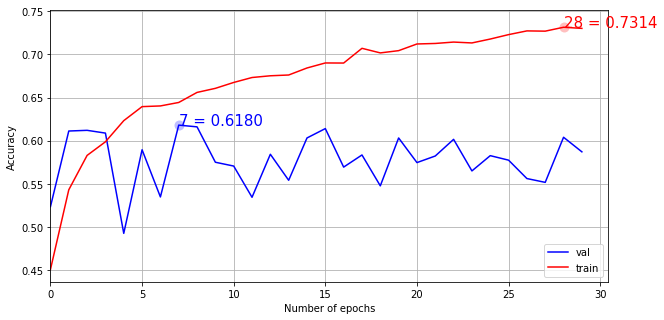

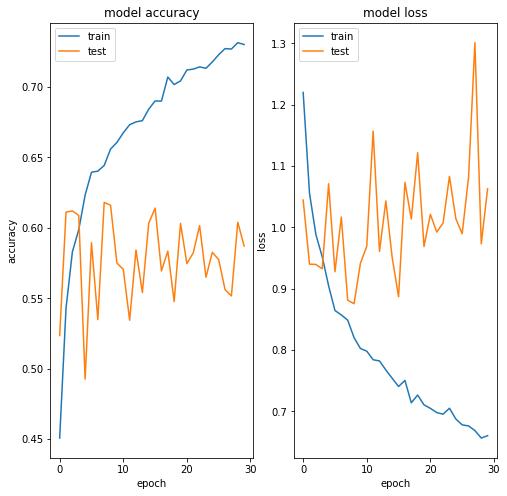

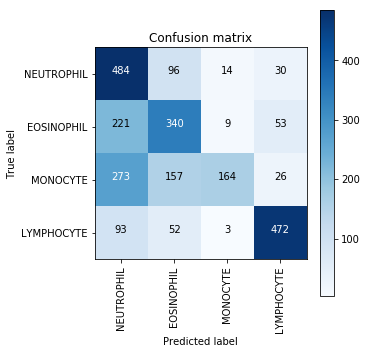

In [39]:
def runVgg162(x_train, y_train, x_test, y_test, epochs=30, batch_size=32, learning_rate=0.001, lr_decay=0.9, shift_fraction=0.1,
            save_dir='./result_vgg16'):
    
    num_classes = len(y_train[0])
    model_name = 'vgg16'
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    img_rows, img_cols, img_num_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (img_rows, img_cols, img_num_channels)
    
    model = build_keras_model(model_name, num_classes, input_shape)
    
    history = train_model(
        model, x_train, y_train, x_test, y_test, learning_rate=learning_rate, lr_decay=lr_decay,
        metrics=['accuracy'], batch_size=batch_size, epochs=epochs, save_dir=save_dir)
    
    test_model(model, x_test, y_test, history)
    
runVgg162(X_train_2, y_trainHot_2, X_test_2, y_testHot_2)

In [40]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [ ]:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
def runKerasCNNAugment(a,b,c,d,e):
    batch_size = 128
    num_classes = len(b[0])
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss= 'categorical_crossentropy',
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1)

In [ ]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Test'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Test'], loc='lower right')

Y_pred = model.predict(test_dataset, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(test_label,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(test_label,axis=1),y_pred)
print(cm)
 
# Visualizing of confusion matrix
 
df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

In [ ]:
def build_grid_model(num_classes, input_shape):
   
    activation='relu' # or linear
    dropout_rate=0.2 # or 0.2
    weight_constraint=0 # or  4
    optimizer='adam' # or SGD
    lr = 0.01
    momemntum=0




    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation=activation, input_shape=input_shape,strides=1))
    model.add(Conv2D(64, kernel_size=(3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(256, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation= activation, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    return model

def train_model(model, x_train, y_train, x_test, y_test, learning_rate=0.001, lr_decay=0.9,
                metrics=['accuracy'], batch_size=100, epochs=30, shift_fraction=0.1, save_dir='./result'):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """

    # callbacks
    checkpoint = ModelCheckpoint(save_dir + '/weights-{epoch:02d}.h5', monitor='val_acc',
                                           save_best_only=True, save_weights_only=True, verbose=0)
    # lr_decay_callback = LearningRateScheduler(schedule=lambda epoch: learning_rate * (lr_decay ** epoch))

    # compile the model
    model.compile(optimizer= Adadelta(), loss=['categorical_crossentropy'], metrics=['accuracy'])

    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    history = model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size), 
        steps_per_epoch=len(x_train) / batch_size, 
        epochs=epochs, 
        validation_data = [x_test, y_test],
        # callbacks = [checkpoint, lr_decay_callback]
        callbacks = [checkpoint]
    )
    
    model.save_weights(save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % save_dir)

    return history

def test_model(model, x_test, y_test, history):
    score = model.evaluate(x_test, y_test, verbose=True)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(x_test)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(y_test,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()

In [ ]:



model = KerasClassifier(build_fn=build_grid_model, batch_size=32, epochs=50) 
# use verbose=0 if you do not want to see progress

########################################################
# Use scikit-learn to grid search 
activation =  ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'] # softmax, softplus, softsign 
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weight_constraint=[1, 2, 3, 4, 5]
neurons = [1, 5, 10, 15, 20, 25, 30]
optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
##############################################################
# grid search epochs, batch size
epochs = [40, 50, 80, 100] # add 50, 100, 150 etc
batch_size = [32, 40, 50, 64] # add 5, 10, 20, 40, 60, 80, 100 etc
param_grid = dict(epochs=epochs, batch_size=batch_size)
##############################################################
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X, Y) 
##############################################################
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
##############################################################